In [254]:
import ast
import pandas as pd
import numpy as np
import torch
from tensorflow import keras
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from torch import tensor

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 250,250



In [255]:
csv_path = keras.utils.get_file(
    "250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("~/.keras/datasets/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249455 entries, 0 to 249454
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   smiles  249455 non-null  object 
 1   logP    249455 non-null  float64
 2   qed     249455 non-null  float64
 3   SAS     249455 non-null  float64
dtypes: float64(3), object(1)
memory usage: 7.6+ MB


In [256]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br", None]'  #wyrzucić B, Br,  P, I

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3, "SELF": 4}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC, 4: "None"}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
MAX_BONDNUM = 150
MAX_MOLSIZE = 64 #max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 32
EPOCHS = 500

VAE_LR = 5e-4
NUM_ATOMS = 32  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5  # Number of bond types
LATENT_DIM = 128  # Size of the latent space

In [259]:
def edge_idx_to_adj(edge_index, edges_attr):
    #print(edges_attr)
    adj = np.zeros((NUM_ATOMS, NUM_ATOMS))
    attr_matrix = np.zeros((NUM_ATOMS, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        print(k, j)
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    return torch.tensor(adj), torch.tensor(attr_matrix)

def batch_edge_idx_to_adj(edge_index, edges_attr):
    adj = np.zeros((BATCH_SIZE*NUM_ATOMS, BATCH_SIZE*NUM_ATOMS))
    attr_matrix = np.zeros((BATCH_SIZE*NUM_ATOMS,BATCH_SIZE*NUM_ATOMS, BOND_DIM))
    adj_reduced = np.zeros((0, NUM_ATOMS))
    attr_reduced = np.zeros((0, NUM_ATOMS, BOND_DIM))
    for i in range(edge_index.shape[1]):
        k = edge_index[0][i]
        j = edge_index[1][i]
        adj[k][j] = 1
        attr_matrix[k][j] = edges_attr[i]
    for i in range(BATCH_SIZE):
        #print(adj.shape, (adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]).shape)
        adj_reduced = np.concatenate([adj_reduced, adj[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS]], axis=0)
        attr_reduced = np.concatenate([attr_reduced, attr_matrix[i*NUM_ATOMS:(i+1)*NUM_ATOMS,i*NUM_ATOMS:(i+1)*NUM_ATOMS,:]], axis=0)
    return torch.tensor(adj_reduced), torch.tensor(attr_reduced)

def molecule_to_graph(molecule):
    # Converts SMILES to molecule object
    
    mol_atoms = molecule.GetNumAtoms()    # Initialize adjacency and feature tensor
    num_of_bonds = molecule.GetNumBonds()
    edge_index = [[],[]]
    edge_features = []
    adj_mat = np.zeros((NUM_ATOMS, ATOM_DIM))
    
    features = np.zeros((NUM_ATOMS, ATOM_DIM))

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        atomic_num = atom.GetAtomicNum()
        degree = atom.GetDegree()
        features[atom_idx] = np.eye(ATOM_DIM)[atom_type] #np.concatenate((np.eye(ATOM_DIM)[atom_type][:-2], chem_features), axis=0)
    for i in range(mol_atoms, NUM_ATOMS):
        features[i][ATOM_DIM-1] = 1
        edge_index[0].append(i)
        edge_index[1].append(i)
        edge_embbeding = list(np.eye(BOND_DIM)[BOND_DIM-1])
        edge_features.append(edge_embbeding)
        # loop over one-hop neighbors
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type_idx = bond_mapping[bond.GetBondType().name]
        edge_index[0] = list(np.append(edge_index[0], [i, j]))
        edge_index[1] = list(np.append(edge_index[1], [j, i]))
        edge_embbeding = list(np.eye(BOND_DIM)[bond_type_idx])
        edge_features.append(edge_embbeding)
        edge_features.append(edge_embbeding)
    return tensor(features), tensor(edge_index), tensor(edge_features)


def graph_to_molecule(graph):  # for edges in adjacency matrix format
    features, adjacency, edge_features = graph

    if adjacency.shape[0] == 2:
       adjacency, edge_features = batch_edge_idx_to_adj(adjacency, edge_features)
    #print(features, adjacency, edge_features)
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    print(adjacency.size())
    for i in range(len(adjacency)):
        adjacency[i][i] = 0

    # Remove "no atoms" & atoms with no bonds
    mol_idx_to_graph_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (adjacency.sum(axis=1) != 0)
    )
    mol_idx_to_graph_idx = np.squeeze(mol_idx_to_graph_idx)

    graph_idx_to_mol_idx = np.full_like([], fill_value=-1, shape=NUM_ATOMS, dtype=int)
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        graph_idx_to_mol_idx[graph_idx] = mol_idx
    
    for mol_idx, graph_idx in enumerate(mol_idx_to_graph_idx):
        atom_type_idx = int(torch.argmax(features[graph_idx]))
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    for mol_idx_1, graph_idx_1 in enumerate(mol_idx_to_graph_idx):
        for mol_idx_2, graph_idx_2 in enumerate(mol_idx_to_graph_idx):
            if adjacency[graph_idx_1][graph_idx_2] > 0.6 and graph_idx_2 > graph_idx_1:
                #print(edge_features[graph_idx_1][graph_idx_2])
                edge_type_encoded = int(np.argmax(edge_features[graph_idx_1][graph_idx_2]))
                #bond_type = bond_mapping[edge_type_encoded]       
                if edge_type_encoded != 4: molecule.AddBond(int(mol_idx_1), int(mol_idx_2), Chem.BondType.SINGLE)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)

    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        print("Sth went wrong")
        return molecule
    #print("OK")
    return molecule

def adj_to_index(adj_matrix, attr_matrix):
    edge_index=[[], []]
    edge_attr = []
    for i, row in enumerate(adj_matrix):
        adj_matrix[i][i]=0 
        for j in range(len(row)):
            if row[j] == 1:
                edge_index[0].append(i)
                #edge_index[0].append(j)
                #edge_index[1].append(i)
                edge_index[1].append(j)
                edge_embedding = attr_matrix[i][j]
                #edge_type_encoded = np.argmax(edge_embedding)
                edge_attr.append(edge_embedding)
    return torch.tensor(edge_index), torch.tensor(edge_attr)


def concat_features(features, edge_index, edges_attr):
    if edge_index.shape[0]==2:
        edges_adj = edge_idx_to_adj(edge_index, edges_attr)
    else: edges_adj = edges_attr
    res = torch.cat((features, edges_adj), dim=1)
    return res


In [232]:
z = np.array([[1,2,3]])
y = np.array([[4,5,6]])
np.concatenate([z, y], axis = 0)

array([[1, 2, 3],
       [4, 5, 6]])

In [233]:
from sklearn.discriminant_analysis import StandardScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


class Featurizer():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            smiles = row["smiles"]
            molecule = Chem.MolFromSmiles(smiles)
            if molecule.GetNumAtoms() < 32:
                features, edge_index, edge_attr = molecule_to_graph(molecule) 
                graphs.append((features, edge_index, edge_attr))
                labels.append(molecule)
            
        return [Data(
            features=features.float(), 
            edge_index=edge_index.int(), 
            edge_attr=edge_attr.float(),
            mol=labels)
            for ((features, edge_index, edge_attr), labels) in zip(graphs, labels)]

In [234]:
import sklearn
from sklearn import model_selection
from torch.utils.data import DataLoader

train_data, test_data = model_selection.train_test_split(df, test_size=0.2)

In [235]:
featurizer = Featurizer()
data_train = featurizer(train_data[:1024])
data_val = featurizer(test_data[:128])

from torch_geometric.loader import DataLoader
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE)

In [236]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [237]:
def temperature(input, t=1.0):
  return input/t

In [261]:
from torch_geometric.nn import GATConv, global_mean_pool
#import torch.nn.functional as F
from torch.nn.functional import dropout, one_hot
import torch


HIDDEN_SIZE=512

class Encoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)

        self.conv = [
            GATConv(atom_dim, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size),
            GATConv(hidden_size, hidden_size)
        ]
        self.pooling = global_mean_pool
        self.dense = [
            torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        ]
        self.mean = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.std = torch.nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.elu = torch.nn.ELU() 


    def forward(self, x, edge_index, edge_attr, batch): 
        for conv_layer in self.conv:
            x = conv_layer(x, edge_index, edge_attr)
            x = self.elu(x)    # definiować w konstruktorze
        #print(batch)
        #print("before pooling ", x.shape)
        x = self.pooling(x, batch=batch) #, size = x.shape[1])#[0]
        #print("after pooling ", x.shape)
        #x = torch.flatten(x)
       # print("after flattening ", x.shape)
        for layer in self.dense:
            x = layer(x)
            x = self.elu(x)
        #print("after densing ", x.shape)
        mu, std = self.mean(x), self.std(x)
        #print("mu, std: ", mu.shape, std.shape)
        return mu, std
    
    def loss():
        pass

class Decoder(torch.nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM) -> None:
        super(Decoder, self).__init__()
        torch.manual_seed(12345)
        self.edges_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS), out_features=int(NUM_ATOMS)*int(NUM_ATOMS))
        ]

        self.edges_types_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5, out_features=int(NUM_ATOMS)*int(NUM_ATOMS)*5)
        ]

        self.nodes_from_latent = [
            torch.nn.Linear(in_features=latent_dim, out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM)),
            torch.nn.Linear(in_features=int(NUM_ATOMS)*int(ATOM_DIM), out_features=int(NUM_ATOMS)*int(ATOM_DIM))
        ]
        self.elu = torch.nn.ELU()

    def forward(self, z_latent, batch = False):
        edges = torch.clone(z_latent)
        for layer in self.edges_from_latent:
            edges = layer(edges)
            edges = self.elu(edges)

        if batch == False:
            edges = torch.reshape(edges, (NUM_ATOMS, NUM_ATOMS)) + torch.transpose_copy(torch.reshape(edges, (NUM_ATOMS, NUM_ATOMS)), 0, 1)
        else:
            edges_resh = torch.Tensor(size=(0, NUM_ATOMS))
            for row in edges:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, NUM_ATOMS)) + torch.transpose_copy(torch.reshape(row, (NUM_ATOMS, NUM_ATOMS)), 0, 1)
                edges_resh = torch.cat((edges_resh, row_reshaped), 0)
            edges = edges_resh

            if (i := BATCH_SIZE*NUM_ATOMS - edges.size(0)) > 0:
                    edges = torch.cat((edges, torch.zeros(i, NUM_ATOMS)), 0)
        edges = temperature(edges, t=0.2)
        edges = torch.sigmoid(edges)


        edges_attr = torch.clone(z_latent)
        for layer in self.edges_types_from_latent:
            edges_attr = layer(edges_attr)
            edges_attr = self.elu(edges_attr)
        if batch == False:
            edges_attr = torch.reshape(edges_attr, (NUM_ATOMS, NUM_ATOMS, 5)) + torch.transpose_copy(torch.reshape(edges_attr, (NUM_ATOMS, NUM_ATOMS, 5)), 0, 1)
        else:
            edges_attr_resh = torch.Tensor(size=(0, NUM_ATOMS, BOND_DIM))
            for row in edges_attr:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, NUM_ATOMS, BOND_DIM)) + torch.transpose_copy(torch.reshape(row, (NUM_ATOMS, NUM_ATOMS, BOND_DIM)), 0, 1)
                edges_attr_resh = torch.cat((edges_attr_resh, row_reshaped), 0)
            edges_attr = edges_attr_resh

            if (i := BATCH_SIZE*NUM_ATOMS - edges_attr.size(0)) > 0:
                    edges_attr = torch.cat((edges_attr, torch.zeros(i, NUM_ATOMS, BOND_DIM)), 0)

        edges_attr = torch.tensor(edges_attr, dtype=float)
        edges_attr = temperature(edges_attr, t=0.3)
        edges_attr = torch.softmax(edges_attr, dim= 1)
        

        nodes = torch.clone(z_latent)
        for layer in self.nodes_from_latent:
            nodes = layer(nodes)
            nodes = self.elu(nodes)
        if batch == False:
            nodes = torch.reshape(nodes, (NUM_ATOMS, ATOM_DIM))
        else:
            nodes_resh = torch.Tensor(size=(0, ATOM_DIM))
            for row in nodes:
                row_reshaped = torch.reshape(row, (NUM_ATOMS, ATOM_DIM))
                nodes_resh = torch.cat((nodes_resh, row_reshaped), 0)
            nodes = nodes_resh

            #if (i := BATCH_SIZE*NUM_ATOMS - nodes.size(0)) > 0:
            #        nodes = torch.cat((nodes, torch.zeros(i, ATOM_DIM)), 0)
    
        nodes = torch.tensor(nodes, dtype=float)
        nodes = temperature(nodes, t=0.3)
        nodes = torch.softmax(nodes, dim= 1)
        return nodes, edges, edges_attr

    def loss():
        pass

 

class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, encoder, decoder, hidden_size, atom_dim = ATOM_DIM, latent_dim=LATENT_DIM):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(12345)

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

        #decode edges:
        
    
    def encode(self, features, edge_index, edge_attr, batch):
        return self.encoder(features, edge_index, edge_attr, batch)

    def reparametrize(self, mu, std):
        eps = torch.randn_like(std)
        z_reparametrized = mu + std*eps
        return z_reparametrized
        

    def decode(self, z_latent, batch = False):
        return self.decoder(z_latent, batch)

    def forward(self, features, adj, edge_attr, batch):
        mu, std = self.encode(features, adj, edge_attr, batch)
        z = self.reparametrize(mu, std)
        batch = True if len(batch)>32 else False
        nodes_dec, edges_dec, edges_attr_dec = self.decode(z, batch)

        return nodes_dec, edges_dec, edges_attr_dec
    

    # def reconstruction_loss(self, nodes_generated, nodes_real, edges_generated, edges_real, edges_attr_generated, edges_attr_real):
    #     loss = torch.nn.CrossEntropyLoss()
    #     nodes_loss = loss(nodes_generated, nodes_real)
    #     edges_loss = loss(edges_generated, edge_idx_to_adj(edges_real))
    #     edges_attr_loss = loss(edges_attr_generated, edges_attr_real)
    #     return nodes_loss + edges_loss + edges_attr_loss

    def eval(self, test_data_loader):
        loss_fn = torch.nn.CrossEntropyLoss()
        loop = tqdm(enumerate(train_loader))
        for i, data in loop:
            data = data.to(device)

            real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
            mu, std = self.encode(real_features, real_edge_index, real_edge_attr, batch)
            z_reparametrized = self.reparametrize(mu, std)

            features_decoded, edges_decoded, edges_attr_decoded = self.decode(z_reparametrized, batch=True)
                
            real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adjacency(real_edge_index, real_edge_attr, batch)

            features_loss = loss_fn(one_hot(torch.argmax(features_decoded, dim=1), num_classes = ATOM_DIM).to(torch.float64), real_features)
            edges_loss = loss_fn(edges_decoded, real_adj_edges)
            edges_attr_loss = loss_fn(one_hot(torch.argmax(edges_attr_decoded, dim=2), num_classes = BOND_DIM).to(torch.float64), real_adj_edge_attr)

            reconstruction_loss = features_loss + edges_loss + edges_attr_loss
            kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
            loss = 5*reconstruction_loss + kl_div
            print("feat, edges, edges_attr, kl ", features_loss, edges_loss, edges_attr_loss, kl_div)
            print("total ", loss)



In [239]:
encoder = Encoder(hidden_size=HIDDEN_SIZE)
decoder = Encoder(hidden_size=HIDDEN_SIZE)

encoder=encoder.float()
decoder = decoder.float()
g = GraphNeuralNetwork(hidden_size=512, encoder=encoder, decoder=decoder)
#g=g.float()


In [240]:
from numpy import int64
from torch.nn.functional import one_hot

def train(model, train_loader, valid_loader, l_r = 0.00001, epochs = 1000):
        learning_rate = l_r
        #entropy_fn = torch.nn.Entropy() # TODO <- for delete uncertainity
        optimizer = torch.optim.Adam(params=model.parameters(), lr= learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoch in trange(1, epochs + 1, leave=False):
            loop = tqdm(enumerate(train_loader))
            for i, data in loop:
                data = data.to(device)

                real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
                mu, std = model.encode(real_features, real_edge_index, real_edge_attr, batch)
                z_reparametrized = model.reparametrize(mu, std)

                features_decoded, edges_decoded, edges_attr_decoded = model.decode(z_reparametrized, batch=True)
                #print(real_features[:,0:1])
                #print(features_decoded[:,0:1], "\n")
                real_adj_edges, real_adj_edge_attr = batch_edge_idx_to_adjacency(real_edge_index, real_edge_attr, batch)

                # softmax + temperature
                features_loss = loss_fn(features_decoded, real_features)
                edges_loss = loss_fn(edges_decoded, real_adj_edges)
                edges_attr_loss = loss_fn(edges_attr_decoded, real_adj_edge_attr)

                reconstruction_loss = features_loss + edges_loss + edges_attr_loss
                kl_div = -torch.sum(1 + torch.log(std.pow(2)) - mu.pow(2) - std.pow(2))
                loss = 5*reconstruction_loss + kl_div
                print(loss)
                loss.backward()
                optimizer.step() 
                optimizer.zero_grad()
                model.zero_grad()


In [241]:
from torch.nn.functional import one_hot

loop = tqdm(enumerate(val_loader))
for i, data in loop:
    if i > 0:
        break
    #print(data.features)
    real_features, real_edge_index, real_edge_attr, batch, mol = data.features, data.edge_index.to(dtype=torch.int64), data.edge_attr, data.batch, data.mol
    print(batch.shape, batch)
    #print(real_features, real_edge_index, real_edge_attr)
    mu, std = g.encode(real_features, real_edge_index, real_edge_attr, batch)
                #real_features = F.one_hot(torch.argmax(real_features, dim=1), ATOM_DIM)
    z_reparametrized = g.reparametrize(mu, std)
    features_decoded, edges_decoded, edges_attr_decoded = g.decode(z_reparametrized, batch = True)
    #print(features_decoded, one_hot(torch.argmax(features_decoded, dim=1), num_classes = ATOM_DIM).to(torch.float64))
    f, e, e_a = features_decoded[:32], edges_decoded[:32], edges_attr_decoded[:32]
    f = one_hot(torch.argmax(f, dim=1), num_classes = ATOM_DIM).to(torch.float64)
    e_a = one_hot(torch.argmax(e_a, dim=2), num_classes = BOND_DIM).to(torch.float64)
    print(f.size(), e.size(), e_a.size())
    mol = graph_to_molecule((f, e, e_a))
    mol = Chem.rdchem.Mol(mol)
    #mol_tru = graph_to_molecule((real_features[:32], real_edge_index[0], real_edge_attr[0]))
    #Draw.MolToImage(mol)      # Why does it not appear, while drawing in the loop?

0it [00:00, ?it/s]

torch.Size([1024]) tensor([ 0,  0,  0,  ..., 31, 31, 31])
torch.Size([32, 12]) torch.Size([32, 32]) torch.Size([32, 32, 5])
torch.Size([32, 32])


In [250]:
concat_features(f, e, e_a)

NameError: name 'edge' is not defined

In [243]:
e

tensor([[0.0000, 0.6203, 0.5210,  ..., 0.4920, 0.5500, 0.5191],
        [0.6203, 0.0000, 0.4783,  ..., 0.5670, 0.5121, 0.5459],
        [0.5210, 0.4783, 0.0000,  ..., 0.5507, 0.4841, 0.5302],
        ...,
        [0.4920, 0.5670, 0.5507,  ..., 0.0000, 0.5041, 0.5152],
        [0.5500, 0.5121, 0.4841,  ..., 0.5041, 0.0000, 0.5228],
        [0.5191, 0.5459, 0.5302,  ..., 0.5152, 0.5228, 0.0000]],
       grad_fn=<AsStridedBackward0>)

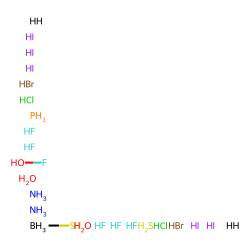

In [244]:
mol

In [245]:
true_mol = graph_to_molecule((real_features, real_edge_index, real_edge_attr))

torch.Size([1024, 32])


IndexError: index 32 is out of bounds for dimension 0 with size 32

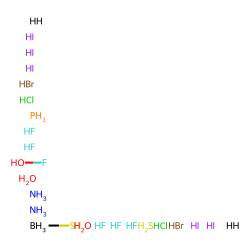

In [247]:
mol

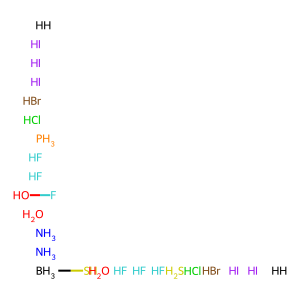

In [248]:
Draw.MolToImage(mol)

In [249]:
mol = graph_to_molecule((f, e, e_a))

torch.Size([32, 32])


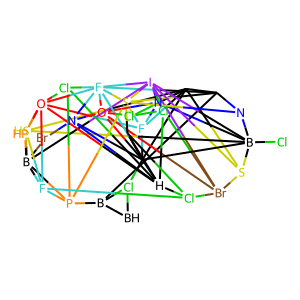

In [ ]:
Draw.MolToImage(mol) 

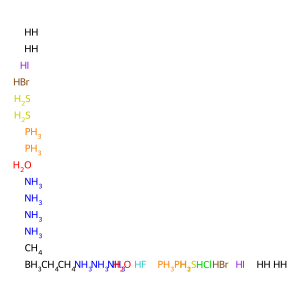

In [ ]:
Draw.MolToImage(mol) 

In [ ]:

#train(g, train_loader=train_loader, valid_loader=val_loader, epochs = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

tensor(29365.3836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(29291.6230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(29138.6790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(29190.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(29120.0317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28888.0830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28806.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28719.2978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28685.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28661.8614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28564.6677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28467.3630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28532.3230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28334.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28298.8244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(28190.4593, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(27414.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27444.7016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27275.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27380.6146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27278.7488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27136.7037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27047.0522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27038.4217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27037.9935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(27072.0988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26981.2583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26856.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26940.2603, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26819.8060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26804.6229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26728.5589, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(26149.0677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26150.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26053.6449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26163.5822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(26070.6825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25990.1151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25864.9794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25859.7915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25918.4776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25860.0803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25836.3218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25778.6708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25812.3815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25691.5259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25704.5380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25677.3696, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(25213.7615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25205.4355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25131.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25203.1580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25123.9938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25080.4897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24977.7762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24947.4070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(25018.0766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24997.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24932.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24926.1434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24944.4775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24873.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24841.8983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24817.7079, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(24433.4254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24452.0832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24352.6798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24442.3479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24364.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24291.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24217.0384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24206.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24254.9455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24202.5515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24168.6936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24153.0611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24198.8295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24115.8146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24118.8670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(24055.9588, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(23726.9772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23796.1677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23678.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23727.2040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23700.9751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23636.1008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23576.5561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23557.5312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23613.5685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23553.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23528.9460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23502.2173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23567.9711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23464.7406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23472.8752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23409.1977, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(23141.3020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23169.0197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23066.4571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23113.3613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23065.3483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23048.4677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23003.2546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22956.4838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(23013.9104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22938.9280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22961.3679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22914.6983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22987.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22890.9206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22884.1801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22848.7861, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(22605.4685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22637.7409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22541.2805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22601.1188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22554.5927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22524.2729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22457.8711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22448.7801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22513.0546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22452.7016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22450.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22387.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22477.6847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22383.4929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22383.8280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22341.6225, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(22125.5233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22133.0838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22052.7828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22101.0454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22062.9066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22025.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21973.0523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21952.0774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22023.9954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21946.5733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21949.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21917.6142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(22003.5292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21882.4938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21887.7822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21864.5191, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(21643.6964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21668.2332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21590.7783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21627.7372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21591.1429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21550.6761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21520.3194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21484.0150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21563.2673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21512.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21519.5355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21471.5526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21522.7278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21442.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21457.1025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21408.8629, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(21226.5297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21230.0233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21173.8006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21206.1469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21162.9395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21134.3722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21100.5129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21083.4462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21145.5457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21088.3745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21123.2432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21054.5779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21085.0495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21039.0529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21034.2775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(21012.9625, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(20812.3185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20823.4024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20779.5909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20822.6306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20753.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20737.7604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20724.1818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20678.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20717.7683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20670.6096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20700.0540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20667.9598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20692.2591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20636.9195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20640.0109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20598.1491, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(20437.9272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20467.2598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20400.4403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20444.6710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20399.3793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20388.3517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20360.2933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20319.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20353.8177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20308.2483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20330.7796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20306.5528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20325.0098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20279.2566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20268.2712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20230.3614, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(20096.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20119.0030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20061.9949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20098.7050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20047.9841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20050.3651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20019.4512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19960.3430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(20010.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19983.7668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19991.0496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19972.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19990.8487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19930.1906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19933.1310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19894.4203, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(19758.4204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19753.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19733.0517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19755.9925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19702.2817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19719.4349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19700.6399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19611.9858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19663.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19647.0825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19638.7750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19638.2561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19658.3149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19598.4124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19609.8971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19550.8591, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(19443.2735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19438.1368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19421.7128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19443.6789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19387.1593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19389.4592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19402.7513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19307.7860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19353.1694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19345.3051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19328.9955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19333.2114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19350.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19285.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19302.4760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19236.4126, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(19126.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19134.5064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19117.4495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19140.7995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19055.3280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19072.6291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19088.9051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18993.2259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19035.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19026.3116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19007.1915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19025.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19034.4905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18981.7343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(19012.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18944.1717, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(18826.9574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18840.5601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18828.3600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18850.4521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18774.0975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18791.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18799.7387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18705.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18752.7012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18742.9402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18721.4810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18753.1038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18746.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18705.8275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18731.9330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18654.3100, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(18553.8532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18561.8316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18559.6214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18577.7511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18502.8449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18520.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18531.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18441.4619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18488.6744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18472.4461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18455.8900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18486.2285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18479.4947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18434.4372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18450.1824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18386.0316, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(18285.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18293.9023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18289.6538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18309.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18239.1202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18243.7377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18258.3024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18174.6874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18233.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18220.5496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18199.9147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18222.8956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18214.0172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18166.0101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18192.7344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18136.5907, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(18044.9934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18053.2747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18040.9390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18066.4717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17988.1695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17997.6222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(18018.5863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17932.7278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17992.6217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17981.3778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17953.7528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17979.2334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17982.3703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17923.7617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17946.3471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17889.6057, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(17778.6505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17788.5048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17789.2939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17785.9365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17726.8569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17739.0746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17762.1039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17681.1291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17731.0138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17726.0497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17694.8242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17731.4613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17725.5385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17671.4953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17699.2116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17642.1220, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(17538.9484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17548.7078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17545.2430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17547.7458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17487.8194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17498.3567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17516.5575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17442.1632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17493.6246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17493.6490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17460.3767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17494.3782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17483.9319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17432.6767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17462.2395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17418.4785, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(17321.5088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17343.6450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17313.9265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17331.6111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17267.8228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17274.8755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17288.0433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17216.1407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17263.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17254.4096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17230.1912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17268.7655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17248.8376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17203.7487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17234.6527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17196.0550, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(17092.9820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17107.9850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17081.4232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17093.2428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17044.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17053.8881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17066.9782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16998.6743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17042.1757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17033.3382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17011.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17064.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17031.1615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16992.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(17029.0705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16976.7495, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(16882.2848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16896.9075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16872.3878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16881.7092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16836.3500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16846.5652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16858.8968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16792.4391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16836.6400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16831.2554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16803.9337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16847.9426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16825.6398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16787.1937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16819.7498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16768.7290, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(16678.0660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16688.5826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16670.6272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16676.0285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16632.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16645.7799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16657.9671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16592.7052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16635.1212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16624.9962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16603.5504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16647.4836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16627.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16591.1423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16621.8594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16566.2472, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(16477.8933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16492.4418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16477.2888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16479.7113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16438.2724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16453.4262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16466.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16400.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16442.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16430.2016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16411.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16451.8154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16435.0757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16401.0842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16428.7582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16374.5830, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(16290.8301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16304.1018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16294.3292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16290.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16248.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16262.9246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16277.7321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16212.9146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16250.3282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16236.6975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16223.0069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16265.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16239.4445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16212.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16241.2306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16183.9953, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(16096.4408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16118.8034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16091.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16101.6829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16059.5404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16071.4889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16092.6158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16029.8214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16061.8316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16046.8077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16044.5896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16078.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16052.9401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16019.6912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(16052.2949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15998.5864, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15916.7430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15928.7955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15908.7239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15918.1457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15876.4450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15890.2140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15913.1610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15854.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15883.1118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15867.9219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15860.3591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15904.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15877.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15840.5867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15871.4569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15821.8598, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15738.0172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15751.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15730.6761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15736.7588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15705.0421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15715.8358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15741.6661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15675.6384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15711.4998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15690.3230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15684.6133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15721.8029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15704.5410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15665.2031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15688.6068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15648.9354, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15565.7008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15579.0926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15557.6642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15560.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15529.5401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15545.9314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15566.2964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15505.3485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15539.6991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15521.3327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15515.5281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15551.8879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15525.9398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15495.3607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15517.9878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15479.6320, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15399.1546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15417.1356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15391.6060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15392.4191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15363.4656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15378.5999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15397.1198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15339.9144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15374.6376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15358.6760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15352.1987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15390.8193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15359.4127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15331.1529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15354.0291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15315.7412, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15239.3914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15253.0726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15231.0576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15230.9169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15201.9496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15218.3169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15235.5243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15179.8931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15214.9599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15199.6028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15194.2121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15232.5108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15199.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15171.5490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15194.4899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15157.7329, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(15081.6827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15095.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15075.6557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15076.8007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15049.8714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15064.7199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15080.7225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15025.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15061.1150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15043.1264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15037.6946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15071.4483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15049.7783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15017.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15041.9412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(15004.9372, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14933.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14942.8514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14923.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14923.9752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14894.5849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14911.6962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14927.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14872.8216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14908.6683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14891.6953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14885.9233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14923.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14896.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14865.3352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14889.9428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14855.0635, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14777.1150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14793.4156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14772.9188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14774.3091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14745.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14771.0267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14782.0033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14725.7980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14760.0582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14741.2917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14740.5065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14767.5858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14748.1181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14717.8943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14741.1932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14713.1148, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14629.5605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14647.6835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14626.6777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14628.6279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14598.3186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14619.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14639.5607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14581.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14614.9038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14595.9337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14596.6953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14621.9621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14602.5760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14572.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14596.9987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14569.2882, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14485.9962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14503.3529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14483.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14483.8601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14456.4705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14478.6727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14489.6277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14436.7167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14471.6806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14453.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14450.7823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14478.2470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14460.0788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14428.9784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14460.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14420.3684, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14349.2982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14363.8401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14343.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14341.6768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14315.0932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14333.7365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14346.0692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14295.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14330.7623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14313.7544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14309.9933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14347.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14319.1852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14290.1504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14314.3078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14285.6125, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14210.2139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14237.8002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14206.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14215.8334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14183.4017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14210.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14207.3481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14179.1410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14205.5347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14180.9326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14198.4874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14208.6719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14188.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14170.0181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14183.8451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14154.9496, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(14074.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14097.8897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14071.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14080.4104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14048.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14072.2959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14064.1913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14039.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14071.3537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14045.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14068.5471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14067.7982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14049.5836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14036.5330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14044.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(14019.6470, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13934.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13956.3786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13933.0805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13940.5422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13910.7065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13937.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13928.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13905.8645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13933.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13909.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13925.5478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13937.2494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13911.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13900.4171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13909.0844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13885.2954, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13800.9916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13823.6326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13799.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13804.7036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13777.4659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13804.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13794.9416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13775.6910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13795.0132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13770.3494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13789.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13807.0677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13774.1467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13771.5050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13778.6300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13755.1052, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13669.8865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13692.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13668.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13673.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13649.0687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13672.5769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13665.7030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13644.7440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13665.3042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13640.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13660.7347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13672.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13645.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13648.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13647.7756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13633.2834, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13545.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13567.9191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13543.9455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13548.9886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13524.5407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13548.9403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13541.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13521.2067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13541.6496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13516.5543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13537.2666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13549.8313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13521.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13522.8003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13524.7435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13506.1966, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13422.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13444.3349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13421.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13426.0517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13402.2196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13426.4000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13418.9872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13398.7541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13419.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13394.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13415.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13426.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13399.7118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13402.3677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13402.2449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13386.2299, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13301.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13323.5621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13300.5850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13305.3885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13281.7391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13306.2341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13298.5431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13278.6416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13299.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13273.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13295.1045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13306.4283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13279.7409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13282.3268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13282.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13266.3568, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13182.8116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13204.6251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13181.9898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13186.6646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13163.2612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13187.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13180.0876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13160.4791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13180.8509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13155.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13177.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13188.0573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13161.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13164.5993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13164.0925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13148.9905, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(13066.0332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13087.8422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13065.4212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13069.9595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13046.7583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13071.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13063.6219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13044.3084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13064.6405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13039.3272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13061.0376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13071.7186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13045.7350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13048.6927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13047.9989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(13033.3959, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12951.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12972.9018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12950.6990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12955.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12932.1021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12957.3950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12949.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12929.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12950.2685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12924.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12946.8452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12957.2493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12931.5668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12934.5933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12933.7692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12919.5857, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12838.0068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12859.7513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12837.7541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12842.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12819.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12844.7941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12836.2389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12817.4438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12837.6993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12812.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12834.4085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12844.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12819.1634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12822.2935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12821.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12807.6037, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12726.6588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12748.3695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12726.5800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12730.8002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12708.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12733.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12725.1616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12706.6273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12726.8243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12701.4751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12723.7075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12733.6454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12708.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12711.6631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12710.5972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12697.2211, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12616.9577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12638.6320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12617.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12621.1725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12598.6632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12624.7081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12615.7463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12597.4670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12617.6095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12592.2432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12614.6363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12624.3489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12599.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12602.7501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12601.5155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12588.6535, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12508.8924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12530.5804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12509.1465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12513.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12490.8090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12517.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12507.9807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12489.9154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12510.0338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12484.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12507.1938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12516.7154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12492.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12495.2884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12494.0931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12481.3824, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12402.3593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12423.9669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12402.7540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12406.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12384.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12411.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12401.7108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12383.8503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12403.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12378.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12401.2296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12410.5024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12386.1163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12389.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12388.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12376.3896, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12297.4336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12319.2036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12298.0247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12301.8827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12279.7214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12306.5969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12297.0691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12279.4808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12299.5103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12274.1261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12296.9196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12306.1822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12281.8726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12284.8195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12283.8881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12271.0601, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12193.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12215.1385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12194.4107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12198.1516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12176.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12203.1730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12193.6254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12176.1007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12196.1376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12170.6584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12193.6772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12202.4116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12178.5986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12183.1911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12180.5082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12173.9996, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(12088.1948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12104.2182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12086.5912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12089.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12067.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12093.8218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12086.9648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12067.2858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12086.9875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12060.1723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12085.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12090.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12068.2732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12067.7907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12069.7769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12054.5981, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11983.1711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(12001.0720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11984.1448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11987.8744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11964.0077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11991.6363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11985.3836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11965.4705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11985.0571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11958.0810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11983.3504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11989.1216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11966.4725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11965.7882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11968.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11953.4607, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11882.2567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11900.5826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11883.9646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11887.9931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11863.5475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11891.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11885.6253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11865.5772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11885.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11857.9772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11883.5224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11891.6611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11866.5110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11865.7614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11868.4493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11854.0451, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11783.0795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11801.6578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11785.2730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11789.6996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11764.6840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11793.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11787.2982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11767.1837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11786.5790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11759.3784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11785.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11791.9580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11768.0069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11767.2262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11770.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11755.9870, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11684.9090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11703.8101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11687.6432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11693.0668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11666.8142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11695.5801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11690.1031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11669.8285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11689.1031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11661.7882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11687.8417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11691.8206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11670.5384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11669.7545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11672.7828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11659.1147, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11588.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11607.3167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11591.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11599.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11570.3341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11599.4395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11594.2320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11573.8393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11593.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11565.6330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11591.9194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11594.6732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11574.5370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11573.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11576.9551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11563.6704, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11492.8823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11512.2462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11496.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11503.2581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11475.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11504.6203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11499.6265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11479.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11498.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11470.6363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11497.0971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11498.8187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11479.5794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11478.8708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11482.1661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11469.2884, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11398.4267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11418.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11402.3530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11406.6022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11381.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11410.7068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11406.1073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11385.2904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11404.3008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11376.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11403.3669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11404.1733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11385.7236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11385.0819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11388.5521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11376.0976, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11305.2311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11325.2200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11309.5145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11312.5795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11288.0764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11318.0149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11313.7968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11292.7178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11311.6263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11283.9271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11310.8064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11310.8941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11293.0766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11292.5034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11296.1103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11284.1208, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11213.2291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11233.5090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11217.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11220.0756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11196.2624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11226.4775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11222.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11201.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11220.1195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11192.3252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11219.3754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11218.8755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11201.5549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11201.0814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11204.8296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11193.3224, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11122.3703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11142.9712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11127.2404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11128.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11105.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11136.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11132.6664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11110.9419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11129.7339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11101.8614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11129.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11128.0963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11111.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11110.8177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11114.6902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11103.7718, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(11032.5122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11053.5221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11037.6256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11038.6545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11015.8513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11046.5342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11043.8362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11021.4952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11040.2133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11012.2475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11039.6310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11038.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11021.6322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11021.3560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11025.4128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(11015.1802, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10943.5599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10965.1907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10948.9820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10949.4737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10927.1086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10958.0356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10956.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10933.1086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10951.7501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10923.7225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10951.2631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10949.2178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10933.1991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10933.0154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10937.2831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10927.9774, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10855.7743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10878.1118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10861.4552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10861.5078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10839.4994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10870.6376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10870.4329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10845.8066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10864.3788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10836.3107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10863.9860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10861.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10845.8830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10845.7954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10850.2368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10842.4922, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10769.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10792.2671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10775.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10774.7959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10753.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10784.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10787.7999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10759.6437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10778.2239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10750.1279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10777.9500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10775.3119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10759.8819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10759.8967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10764.4240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10764.2328, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10681.2508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10704.0172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10687.4015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10686.6040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10665.0573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10696.8578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10699.6999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10672.0914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10690.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10662.1660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10690.2693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10687.1316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10672.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10672.2858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10676.3842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10664.6626, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10596.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10619.2223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10602.8369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10601.9457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10580.5611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10612.5850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10615.5702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10587.8829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10606.3849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10577.9956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10606.1814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10602.9831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10587.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10588.3655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10592.4228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10580.5669, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10513.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10535.8754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10519.5698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10518.6239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10497.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10529.4710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10532.5828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10504.7835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10523.3174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10494.9133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10523.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10519.8775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10505.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10505.4663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10509.4761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10497.5189, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10430.6209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10453.3867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10437.1877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10436.1927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10414.9830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10447.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10450.2804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10422.5559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10441.1041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10412.7015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10440.9689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10437.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10422.8970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10423.4193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10427.3702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10415.3393, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10348.9787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10371.7781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10355.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10354.5850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10333.4797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10365.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10368.9239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10341.1550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10359.7156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10331.3265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10359.6366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10356.2409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10341.6138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10342.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10346.1121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10334.0236, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10268.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10290.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10274.9372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10273.8222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10252.7822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10285.2750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10288.1527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10260.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10279.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10250.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10279.0990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10275.6544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10261.1249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10261.8026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10265.6645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10253.4996, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10188.1686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10210.9749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10194.9794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10193.8346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10172.8917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10205.4815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10208.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10180.7982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10199.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10171.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10199.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10195.8818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10181.4796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10182.2435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10186.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10173.8366, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10108.9896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10131.7155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10115.8819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10114.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10093.8311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10126.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10128.8749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10101.7993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10120.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10092.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10120.3866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10116.8197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10102.5465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10103.3832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10107.1141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10094.8763, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(10030.4588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10053.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10037.4524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10036.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10015.4341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10048.2240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10051.9691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10023.5272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10042.2579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10013.9059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10042.3016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10038.7374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10024.5894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10025.5649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10029.1711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(10016.9199, dtype=torch.float64, 

0it [00:00, ?it/s]

tensor(9953.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9975.4417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9960.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9958.9109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9938.1423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9970.9774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9971.0615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9946.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9964.9645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9936.5228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9964.8570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9961.1394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9947.1065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9948.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9951.7395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9939.4146, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9875.7800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9898.7378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9882.9269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9881.6360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9861.0684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9893.9289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9900.7795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9869.3339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9888.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9860.8847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9889.3536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9886.5092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9872.5874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9874.2109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9876.9319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9864.9966, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9803.4815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9823.1845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9809.8935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9809.6973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9787.4844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9823.2882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9821.1044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9798.5252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9813.1609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9786.0524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9810.2393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9825.6183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9796.8091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9787.9138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9793.6670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9780.9022, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9712.8722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9729.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9726.8007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9712.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9692.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9720.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9725.9884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9693.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9718.5194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9696.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9700.1841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9722.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9697.9467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9689.7170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9706.6202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9687.0679, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9634.2256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9651.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9648.7611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9632.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9612.9958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9639.6575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9647.3346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9612.6351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9642.8459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9617.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9620.4939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9643.7648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9618.3354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9611.4032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9628.7082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9609.0911, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9555.0796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9578.0645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9571.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9555.6987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9535.3815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9561.9892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9572.3254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9534.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9560.6375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9540.8985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9542.5294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9562.4426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9540.5317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9536.3746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9556.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9532.7359, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9476.7586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9502.8298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9493.5974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9481.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9459.6559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9486.7896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9503.4592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9459.0299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9484.0477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9472.7282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9467.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9486.7702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9465.8010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9465.5380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9477.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9458.9590, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9403.9639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9429.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9420.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9409.2842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9387.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9414.4765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9426.5802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9386.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9411.4322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9398.8852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9394.2710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9413.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9392.3044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9388.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9402.5798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9385.5099, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9328.2420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9353.9036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9346.0980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9336.0809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9312.8436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9343.5430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9362.7495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9311.3138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9334.3440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9315.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9316.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9333.5193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9313.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9307.2054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9327.0376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9308.0556, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9245.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9267.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9265.6365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9250.6912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9231.1582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9260.2065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9265.8838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9231.9343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9254.6205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9234.9925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9238.5136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9254.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9235.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9229.8969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9245.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9233.7072, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9172.2123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9193.4389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9193.1214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9176.5542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9158.3325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9185.1199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9192.7272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9159.4725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9181.4552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9161.4784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9165.6869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9181.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9162.8328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9156.8230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9171.7483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9162.3858, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9099.8038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9121.1676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9122.0745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9104.0794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9086.6275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9112.2715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9122.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9088.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9109.4743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9089.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9093.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9110.6395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9091.1655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9085.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9099.6325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9092.1449, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(9028.5226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9049.9627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9052.1919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9032.7848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9015.8096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9040.7997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9054.6572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9017.7665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9038.3555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9018.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9022.8820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9040.4706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9020.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9013.8786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9028.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9023.1794, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8957.4398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8979.0099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8984.4608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8961.7179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8945.2755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8969.4975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8978.7313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8948.1311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8967.6201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8947.2346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8952.4111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8972.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8949.7617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8943.6132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8957.4869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8956.1465, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8887.8558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8909.4123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8921.3166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8891.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8875.6548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8899.2190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8907.4328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8880.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8897.2350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8876.6653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8881.9944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8899.0963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8879.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8873.2318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8886.3309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8888.6642, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8816.9986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8838.8305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8846.8571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8821.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8805.7480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8828.5810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8836.9445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8809.7757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8827.3512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8806.8196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8812.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8827.9952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8809.8415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8804.1605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8816.7111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8814.4739, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8747.7324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8769.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8772.3865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8752.2036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8736.9282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8759.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8768.7356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8739.1932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8758.3887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8737.8509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8743.5965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8758.3008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8741.1308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8735.9430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8747.7422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8743.8228, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8679.4747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8701.4803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8702.7923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8684.0283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8668.9890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8691.0761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8708.9594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8671.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8691.2378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8671.0956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8677.2520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8692.6581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8675.2599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8669.9291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8682.5342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8683.1719, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8616.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8637.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8644.7317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8620.7472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8605.2598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8628.9730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8637.0991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8613.2533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8627.6691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8607.2081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8613.0025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8629.7105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8610.3069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8604.6567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8617.3027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8618.8116, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8549.9938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8571.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8579.0825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8554.2557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8538.9095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8562.5291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8570.6034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8547.1156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8561.2196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8540.6812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8546.5113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8562.2544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8543.7203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8538.2012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8550.4595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8552.2584, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8483.6470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8505.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8513.0776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8487.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8472.7725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8496.1169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8504.2689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8477.5934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8494.9133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8474.3696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8480.3356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8495.3058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8477.5787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8472.2865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8484.1598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8483.2491, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8417.2316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8438.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8442.3882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8421.5334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8406.7264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8429.6124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8438.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8409.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8428.6683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8408.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8414.2084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8428.3177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8411.5264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8406.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8417.8839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8415.2413, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8351.5738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8373.1012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8375.2954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8355.9409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8341.3668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8363.9520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8378.2596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8343.8188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8363.3326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8342.8300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8349.1133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8362.8446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8346.5421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8342.1294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8352.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8349.9597, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8287.3014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8308.7881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8310.8811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8291.6917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8277.2207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8299.8300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8313.1476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8279.4812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8298.9816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8278.3541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8284.6139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8297.8117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8281.8927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8278.1268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8287.8975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8284.2714, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8222.2850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8243.9063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8244.5939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8226.7795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8212.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8234.7278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8242.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8214.0530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8234.1781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8213.6107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8219.9902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8232.7117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8217.3826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8215.8093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8223.2736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8219.1839, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8159.6215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8181.6910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8181.4153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8164.6499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8150.5165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8172.3821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8178.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8151.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8172.1060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8151.6981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8158.0546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8170.8692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8155.8015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8155.1897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8161.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8156.1155, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8096.9062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8119.1038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8117.8514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8101.8020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8087.7119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8109.1977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8114.4559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8088.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8108.8937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8088.5093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8094.8435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8107.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8092.6133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8088.8153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8098.5276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8092.4330, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(8033.8297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8056.0651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8054.3620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8038.7652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8024.8677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8046.1408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8050.6764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8025.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8045.9414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8025.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8031.9785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8044.1163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8029.7525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8024.8964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8035.5304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8029.3351, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7971.2538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7993.4983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7991.4519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7976.2256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7962.5118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7983.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7987.5551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7962.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7983.4793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7963.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7969.6065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7981.4592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7967.4090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7961.8483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7973.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7966.8287, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7909.1674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7931.4310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7929.0934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7914.1881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7900.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7921.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7925.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7900.3979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7921.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7901.1778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7907.7281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7919.3154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7905.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7899.4676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7911.0489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7904.8519, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7847.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7869.8852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7867.2628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7852.6523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7839.2259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7860.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7863.0459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7838.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7860.0645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7839.7252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7846.3150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7857.6905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7844.1573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7837.6959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7849.5448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7843.4082, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7786.5003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7808.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7805.9720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7791.6106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7778.3213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7798.9604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7801.6183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7777.8293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7799.1087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7778.7850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7785.4519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7796.5811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7783.3084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7776.4795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7788.5862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7782.4703, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7726.9120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7749.5127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7746.2419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7732.4283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7719.2039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7739.6542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7742.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7718.4896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7739.9565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7719.7961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7726.4189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7737.6934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7724.5353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7717.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7729.9927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7722.8153, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7667.4582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7690.1198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7686.4083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7672.8433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7659.6521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7679.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7681.9341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7658.6607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7680.1461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7659.9747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7666.6059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7677.6995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7664.6957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7657.1521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7670.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7662.8469, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7607.6980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7630.3569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7626.4811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7613.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7600.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7620.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7621.8994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7598.9548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7620.4585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7600.3304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7606.9761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7617.8783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7605.1006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7597.3551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7610.3220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7603.2617, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7548.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7570.9944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7567.0019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7553.7785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7540.8471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7560.8547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7562.3230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7539.6799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7561.2179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7541.1000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7547.8133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7558.5241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7545.9233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7537.9844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7551.0433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7544.1210, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7489.4560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7512.0874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7507.9728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7494.9116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7482.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7502.0152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7503.2320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7480.8775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7502.4206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7482.3334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7489.0855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7499.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7487.2070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7479.1059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7492.2383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7485.4283, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7431.0631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7453.7260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7449.4951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7436.5913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7423.8853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7443.7088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7444.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7422.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7444.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7424.1148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7430.9009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7441.2912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7429.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7420.7915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7434.0025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7427.2653, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7372.8203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7395.4083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7391.1086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7378.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7365.6693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7385.4045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7386.1744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7364.3512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7385.9151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7365.8269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7372.6796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7382.8032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7370.7816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7362.4101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7375.5836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7369.3154, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7314.9554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7337.5017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7333.2173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7320.4529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7308.0044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7327.6771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7328.2261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7306.6643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7328.2345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7308.1897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7315.0815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7325.0484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7313.1912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7304.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7317.9137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7311.8939, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7257.6644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7280.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7275.8354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7263.1705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7250.8370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7270.4334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7270.7608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7249.4625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7271.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7251.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7257.9437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7267.7579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7256.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7247.4626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7260.6942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7254.9751, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7200.7755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7223.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7218.9018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7206.2967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7194.0929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7213.6157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7213.7629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7192.6866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7214.2634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7194.2337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7201.2214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7210.8630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7199.3363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7190.6478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7203.9096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7198.4779, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7144.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7166.8121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7162.3364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7149.8446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7137.7642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7157.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7157.1763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7136.3139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7157.8849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7137.8776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7144.9068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7154.4029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7143.0227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7134.2325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7147.5114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7142.4048, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7088.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7110.7040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7106.2095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7093.7893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7081.7666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7101.1457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7100.9770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7080.3339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7101.8986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7081.9311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7088.9800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7098.3447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7087.1020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7078.2209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7091.5203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7086.7936, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(7032.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7054.9866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7050.4505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7038.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7026.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7045.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7045.2071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7024.7624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7046.3013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7026.3499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7033.4394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7042.6615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7031.5613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7022.6369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7035.9270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7031.6619, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6977.2568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6999.6840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6995.1107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6982.8299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6971.0459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6990.2914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6989.8048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6969.5605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6991.0742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6971.1570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6978.2900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6987.3802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6976.4057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6967.3978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6980.6918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6977.0005, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6922.3839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6944.7554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6940.1319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6927.9593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6916.2466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6935.4472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6934.8133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6914.7604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6936.2629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6916.3711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6923.5314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6932.4876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6921.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6912.5524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6925.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6922.9035, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6867.8445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6890.2275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6885.5675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6873.4389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6861.8188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6880.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6880.1753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6860.3232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6881.7992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6861.9495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6869.1448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6877.9821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6867.2503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6858.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6871.4323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6869.4915, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6813.6986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6836.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6831.3725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6819.3128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6807.8071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6826.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6825.9856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6806.2675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6827.7642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6807.9333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6815.1280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6823.8480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6813.2527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6804.0469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6817.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6817.4050, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6760.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6782.3295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6777.6170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6765.6405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6754.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6773.2169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6772.1913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6752.6521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6774.1345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6754.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6761.5448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6770.1842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6759.7030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6750.4234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6763.7959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6766.8413, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6706.1666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6728.3976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6723.7328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6711.7183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6700.3847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6719.3924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6718.2460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6698.8917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6720.3306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6700.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6707.7807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6716.2368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6705.8804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6696.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6709.8827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6706.9164, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6652.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6675.1779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6670.5249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6658.5447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6647.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6666.2871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6665.0400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6645.8686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6667.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6647.4691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6654.7966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6663.1141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6652.8688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6643.5808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6656.8306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6653.2175, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6600.2362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6622.4049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6617.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6605.8267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6594.6896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6613.5818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6612.2372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6593.2235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6614.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6594.8220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6602.1837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6610.3850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6600.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6590.9265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6604.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6600.1281, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6547.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6569.9927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6565.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6553.4586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6542.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6561.2342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6559.7954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6540.9566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6562.2823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6542.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6549.9289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6558.0201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6548.0064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6538.6463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6551.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6547.4810, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6495.8342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6517.9439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6513.2736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6501.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6490.4579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6509.2697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6507.7303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6489.0055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6510.3062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6490.6167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6498.0032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6506.0067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6496.1022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6486.6885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6499.9333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6495.2681, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6444.1440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6466.2509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6461.5599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6449.7847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6438.8838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6457.6327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6455.9884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6437.4452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6458.7101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6439.0396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6446.4430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6454.3566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6444.5386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6435.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6448.3167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6443.4368, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6392.8330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6414.8712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6410.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6398.4371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6387.6365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6406.3436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6404.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6386.1800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6407.4351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6387.8083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6395.2171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6403.0243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6393.3253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6383.8480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6397.0614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6391.9762, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6341.8237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6363.8583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6359.1559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6347.4660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6336.7321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6355.3884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6353.5679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6335.3066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6356.4916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6336.9074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6344.3515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6352.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6342.4403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6332.9487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6346.1446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6340.9033, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6291.1702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6313.1431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6308.4714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6296.8281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6286.1441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6304.7642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6302.8398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6284.7237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6305.9013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6286.3074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6293.8122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6301.4133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6291.9026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6282.3907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6295.5601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6290.1463, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6240.8528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6262.8218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6258.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6246.4949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6235.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6254.4805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6252.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6234.5100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6255.6325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6236.0974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6243.5964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6251.1150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6241.6703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6232.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6245.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6239.8089, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6190.8669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6212.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6208.0973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6196.5057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6186.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6204.5233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6202.4623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6184.6018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6205.7154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6186.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6193.7073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6201.1396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6191.8049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6182.2565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6195.4174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6189.7656, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6141.1998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6163.1022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6158.3939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6146.8439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6136.4126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6154.9064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6152.7466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6135.0332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6156.0887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6136.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6144.1493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6151.4959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6142.2400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6132.6921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6145.8224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6140.0671, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6091.8630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6113.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6109.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6097.5276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6087.1587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6105.6014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6103.3766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6085.7564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6106.7983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6087.3564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6094.9103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6102.1787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6093.0028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6083.4427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6096.5401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6090.7162, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(6042.8797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6064.6880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6059.9760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6048.5346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6038.2136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6056.6255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6054.3335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6036.8519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6057.8491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6038.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6046.0046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6053.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6044.0918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6034.4961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6047.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6041.6978, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5994.1738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6015.9481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6011.2662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5999.8296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5989.6119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6007.9646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6005.6060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5988.2310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6009.2170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5989.8171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5997.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6004.5109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5995.5057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5985.9165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5998.9816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5993.0094, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5945.7860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5967.5364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5962.8403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5951.4476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5941.2699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5959.6215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5957.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5939.9356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5960.8656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5941.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5949.0994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5956.1439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5947.2112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5937.6091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5950.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5944.6296, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5897.7358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5919.4369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5914.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5903.3765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5893.2845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5911.5677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5909.0698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5891.9520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5912.8449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5893.5366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5901.1467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5908.1109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5899.2359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5889.6336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5902.6513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5896.5739, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5849.9923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5871.6718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5866.9870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5855.6435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5845.5910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5863.8520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5861.3071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5844.2871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5865.1395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5845.8719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5853.4822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5860.3714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5851.5762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5841.9789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5854.9868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5848.8242, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5802.5413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5824.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5819.5318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5808.2094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5798.2231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5816.4402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5813.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5796.9333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5817.7613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5798.4910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5806.1348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5812.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5804.2380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5794.6281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5807.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5801.4010, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5755.3956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5777.0342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5772.3519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5761.0745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5751.1636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5769.3402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5766.6693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5749.8691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5770.6560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5751.4569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5759.1013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5765.8065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5757.1902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5747.5550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5760.5576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5754.2796, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5708.5928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5730.1694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5725.4847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5714.2308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5704.4012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5722.5258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5719.8325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5703.1373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5723.8460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5704.6829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5712.3657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5719.0269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5710.4587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5700.8234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5713.7878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5707.5025, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5662.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5683.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5678.9306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5667.7167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5657.9344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5676.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5673.2692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5656.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5677.3927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5658.2253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5665.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5672.5119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5664.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5654.3918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5667.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5661.0024, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5615.8251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5637.3255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5632.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5621.5080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5611.7848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5629.8108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5627.0173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5610.5353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5631.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5612.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5619.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5626.2942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5617.8584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5608.2223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5621.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5614.7723, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5569.8975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5591.3671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5586.7171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5575.5678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5565.8909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5583.9177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5581.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5564.6698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5585.2992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5566.2399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5573.9206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5580.3703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5572.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5562.3785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5575.2781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5568.8889, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5524.2596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5545.6941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5541.0803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5529.9348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5520.3253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5538.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5535.3941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5519.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5539.7107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5520.6507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5528.3635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5534.7648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5526.4814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5516.8505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5529.7235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5523.2825, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5478.9468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5500.3033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5495.7058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5484.6019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5475.0300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5493.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5490.0445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5473.8752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5494.4028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5475.3789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5483.1031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5489.4382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5481.2322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5471.5865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5484.4585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5477.9735, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5433.8955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5455.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5450.6223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5439.5681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5430.0602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5447.9801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5444.9867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5428.9027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5449.3903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5430.4522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5438.1510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5444.4170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5436.2746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5426.6324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5439.4530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5432.9665, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5389.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5410.4521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5405.8390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5394.8002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5385.3659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5403.2361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5400.1831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5384.2147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5404.6603, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5385.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5393.4476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5399.6702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5391.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5381.9570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5394.7785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5388.2529, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5344.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5365.9461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5361.3380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5350.3364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5340.9501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5358.7773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5355.7129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5339.8134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5360.2243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5341.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5349.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5355.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5347.1888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5337.5573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5350.3723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5343.8335, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5300.4695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5321.7145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5317.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5306.1654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5296.8349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5314.6128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5311.5146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5295.7131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5316.0658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5297.2444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5304.9446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5311.0475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5303.1023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5293.4611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5306.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5299.6867, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5256.5941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5277.7788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5273.2141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5262.2413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5252.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5270.7294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5267.6059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5251.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5272.2118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5253.4022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5261.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5267.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5259.2808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5249.6676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5262.3929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5255.8325, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5212.9694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5234.1185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5229.5538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5218.6345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5209.4199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5227.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5223.9560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5208.3531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5228.5975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5209.8682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5217.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5223.5764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5215.7394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5206.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5218.8466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5212.2676, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5169.6611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5190.7543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5186.2105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5175.2941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5166.1454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5183.8205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5180.6204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5165.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5185.2984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5166.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5174.3221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5180.2631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5172.4722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5162.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5175.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5168.9708, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5126.5846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5147.6644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5143.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5132.2415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5123.1504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5140.7921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5137.5427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5122.0791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5142.2632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5123.5939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5131.3527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5137.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5129.4918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5119.9210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5132.5666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5125.9830, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5083.8266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5104.8366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5100.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5089.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5080.3964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5098.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5094.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5079.3745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5099.4882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5080.9039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5088.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5094.4538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5086.7871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5077.2235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5089.8482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5083.2471, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(5041.3265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5062.2945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5057.8034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5046.9571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5037.9598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5055.5325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5052.2132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5036.9632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5057.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5038.4600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5046.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5051.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5044.3463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5034.7967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5047.3814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5040.7702, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4999.0981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5020.0416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5015.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5004.7316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4995.7984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5013.3362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5009.9895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4994.8314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5014.8309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4996.2709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5004.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5009.7451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5002.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4992.6586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5005.2326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4998.6195, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4957.1736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4978.0234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4973.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4962.7687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4953.9114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4971.3767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4967.9967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4952.9219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4972.8996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4954.3927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4962.1484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4967.7898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4960.3033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4950.7822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4963.3437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4956.7058, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4915.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4936.3082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4931.8428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4921.1076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4912.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4929.6975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4926.3064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4911.2886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4931.2482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4912.7681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4920.5330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4926.1220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4918.6804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4909.1574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4921.7046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4915.0821, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4874.0489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4894.8405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4890.4050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4879.6606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4870.8947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4888.3090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4884.8731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4869.9568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4889.8485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4871.4226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4879.1832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4884.7361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4877.3648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4867.8498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4880.3456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4873.6969, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4832.9101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4853.6660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4849.2383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4838.5436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4829.8075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4847.1640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4843.7318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4828.8947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4848.7097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4830.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4838.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4843.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4836.2746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4826.7610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4839.2506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4832.6177, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4792.0321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4812.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4808.3300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4797.6649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4788.9746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4806.2973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4802.8207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4788.0694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4807.8681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4789.5320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4797.2861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4802.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4795.4527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4785.9751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4798.4145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4791.7716, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4751.4299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4772.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4767.6844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4757.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4748.3826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4765.6854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4762.1927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4747.5243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4767.2617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4748.9920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4756.7245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4762.1411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4754.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4745.4406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4757.8535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4751.2337, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4711.0908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4731.7081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4727.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4716.7011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4708.1129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4725.3611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4721.8472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4707.2326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4726.9032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4708.6996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4716.4530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4721.8050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4714.6090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4705.1860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4717.5385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4710.9479, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4670.9974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4691.5703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4687.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4676.6186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4668.0517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4685.2546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4681.7460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4667.2267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4686.8307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4668.6541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4676.3939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4681.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4674.6169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4665.1791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4677.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4670.8894, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4631.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4651.7102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4647.3339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4636.7873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4628.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4645.4662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4641.8870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4627.4595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4647.0426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4628.8942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4636.6349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4641.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4634.8222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4625.4223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4637.7644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4631.1206, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4591.5998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4612.0902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4607.7525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4597.1998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4588.7844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4605.8911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4602.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4587.9799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4607.4774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4589.3871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4597.1417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4602.3543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4595.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4585.9302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4598.2077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4591.6068, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4552.3065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4572.7584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4568.3985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4557.8933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4549.5091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4566.6056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4562.9832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4548.6959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4568.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4550.1191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4557.8756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4563.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4556.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4546.6837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4558.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4552.3447, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4513.2931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4533.6458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4529.3336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4518.8671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4510.4950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4527.5580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4523.9156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4509.7301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4529.1473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4511.1486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4518.8669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4524.0151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4517.0954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4507.6999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4519.9618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4513.3468, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4474.4667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4494.7864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4490.4834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4480.0544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4471.7396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4488.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4485.1335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4470.9830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4490.3481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4472.3934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4480.1385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4485.2297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4478.3589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4469.0036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4481.2095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4474.6097, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4435.9539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4456.2328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4451.9391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4441.5197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4433.2483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4450.2047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4446.5857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4432.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4451.8367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4433.9333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4441.6515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4446.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4439.8650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4430.5480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4442.7107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4436.1111, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4397.6762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4417.8849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4413.6238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4403.2075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4395.0168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4411.9224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4408.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4394.3002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4413.5572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4395.7019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4403.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4408.4365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4401.6441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4392.3207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4404.4706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4397.8931, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4359.6365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4379.8194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4375.5642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4365.2056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4357.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4373.9031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4370.2369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4356.3264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4375.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4357.7287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4365.4410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4370.4146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4363.6730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4354.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4366.4895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4359.9076, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4321.8454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4341.9826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4337.7574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4327.3965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4319.2723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4336.1319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4332.4229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4318.5856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4337.7633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4319.9958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4327.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4332.6496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4325.9547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4316.6813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4328.7431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4322.1714, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4284.3668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4304.3968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4300.1689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4289.8746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4281.7873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4298.5868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4294.8963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4281.1318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4300.2012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4282.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4290.2178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4295.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4288.4526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4279.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4291.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4284.6969, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4247.0373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4267.0735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4262.8598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4252.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4244.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4261.2933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4257.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4243.9169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4262.9491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4245.2938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4252.9782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4257.8367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4251.2172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4242.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4254.0066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4247.4695, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4210.0380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4229.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4225.8092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4215.5369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4207.5770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4224.2487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4220.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4206.9353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4225.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4208.3033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4215.9921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4220.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4214.2356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4205.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4217.0300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4210.4810, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4173.2511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4193.1528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4188.9962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4178.7492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4170.8054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4187.4625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4183.7699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4170.1711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4189.1386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4171.5652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4179.2407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4184.0389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4177.5048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4168.3369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4180.2981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4173.7475, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4136.7132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4156.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4152.4165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4142.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4134.3156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4150.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4147.1908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4133.7041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4152.5945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4135.0798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4142.7526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4147.4832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4141.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4131.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4143.7876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4137.2712, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4100.4162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4120.2249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4116.0720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4105.9023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4098.0693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4114.6187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4110.8609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4097.4971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4116.2880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4098.8713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4106.5172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4111.2004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4104.7581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4095.6367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4107.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4101.0079, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4064.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4084.1114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4080.0168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4069.8645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4062.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4078.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4074.8345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4061.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4080.2165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4062.8571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4070.4729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4075.1674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4068.7656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4059.6469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4071.5206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4065.0031, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(4028.5679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4048.2372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4044.1411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4034.0227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4026.2697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4042.7562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4039.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4025.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4044.4366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4027.0615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4034.7030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4039.3687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4032.9824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4023.9144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4035.7291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4029.2759, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3993.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4012.6514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4008.5519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3998.4516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3990.7492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4007.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4003.4012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3990.2207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4008.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3991.5680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3999.1695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4003.7835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3997.4457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3988.4194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4000.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3993.7417, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3957.6780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3977.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3973.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3963.1352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3955.4418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3971.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3968.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3954.9152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3973.5235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3956.2737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3963.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3968.4635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3962.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3953.1702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3964.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3958.4533, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3922.6185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3942.1238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3938.0659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3928.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3920.4087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3936.7359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3932.9725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3919.8951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3938.4257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3921.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3928.8569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3933.3657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3927.1521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3918.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3929.8451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3923.4187, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3887.7284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3907.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3903.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3893.1949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3885.5845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3901.8560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3898.0679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3885.1074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3903.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3886.4178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3894.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3898.5292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3892.3397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3883.3445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3895.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3888.5990, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3853.1286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3872.5258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3868.5524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3858.5765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3851.0018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3867.2946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3863.4718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3850.5424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3868.9398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3851.8647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3859.4633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3863.9070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3857.7525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3848.8306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3860.4560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3854.0252, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3818.7541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3838.1078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3834.1005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3824.1843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3816.6540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3832.8716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3829.0796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3816.2164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3834.5485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3817.5364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3825.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3829.5556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3823.4281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3814.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3826.0947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3819.7238, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3784.6159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3803.9298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3799.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3790.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3782.5402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3798.6970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3794.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3782.1316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3800.4058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3783.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3791.0031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3795.4045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3789.3275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3780.4334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3792.0111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3785.6116, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3750.7458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3769.9693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3766.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3756.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3748.6928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3764.7942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3760.9894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3748.2673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3766.5060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3749.5758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3757.1130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3761.4807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3755.4713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3746.5851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3758.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3751.7467, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3717.0617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3736.2366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3732.2662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3722.4397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3715.0668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3731.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3727.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3714.6538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3732.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3715.9677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3723.4981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3727.8490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3721.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3712.9770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3724.5004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3718.1341, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3683.6217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3702.7522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3698.8066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3688.9928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3681.6428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3697.6786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3693.8428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3681.2588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3699.3623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3682.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3690.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3694.3989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3688.4318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3679.6235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3691.0823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3684.7406, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3650.4365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3669.4847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3665.5396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3655.7818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3648.4968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3664.4362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3660.6139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3648.0941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3666.1463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3649.4322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3656.8905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3661.1782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3655.2572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3646.4654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3657.9093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3651.5810, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3617.4440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3636.4502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3632.5418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3622.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3615.5578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3631.4716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3627.6611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3615.1804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3633.1735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3616.4772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3623.9663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3628.1841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3622.3134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3613.5265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3624.9410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3618.6493, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3584.7092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3603.6451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3599.7690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3590.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3582.8224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3598.6681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3594.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3582.4821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3600.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3583.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3591.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3595.4256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3589.6093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3580.8390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3592.2289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3585.9245, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3552.1879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3571.0698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3567.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3557.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3550.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3566.1638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3562.3179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3550.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3567.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3551.3027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3558.7474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3562.9402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3557.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3548.4082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3559.7327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3553.4917, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3519.9074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3538.7190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3534.8787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3525.2355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3518.0582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3533.8565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3530.0534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3517.7522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3535.5511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3519.0384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3526.4993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3530.6408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3524.8801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3516.1900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3527.4881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3521.2072, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3487.8438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3506.6145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3502.7615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3493.1812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3486.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3501.7592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3497.9605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3485.7292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3503.5001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3487.0499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3494.4500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3498.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3492.8575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3484.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3495.4349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3489.1864, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3456.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3474.7077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3470.8951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3461.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3454.2331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3469.9101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3466.1113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3453.9592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3471.6127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3455.2521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3462.6377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3466.7429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3461.0597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3452.4194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3463.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3457.4038, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3424.4017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3443.0642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3439.2505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3429.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3422.6542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3438.2935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3434.4790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3422.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3440.0132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3423.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3431.0735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3435.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3429.4731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3420.8628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3432.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3425.8350, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3393.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3411.6262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3407.8332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3398.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3391.3097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3406.8681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3403.0621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3391.0426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3408.5980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3392.3200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3399.7051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3403.7424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3398.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3389.5176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3400.6988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3394.4921, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3361.8594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3380.3767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3376.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3367.1332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3360.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3375.7033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3371.8915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3359.9277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3377.4291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3361.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3368.5419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3372.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3366.9988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3358.4541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3369.5550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3363.3861, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3330.9313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3349.4055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3345.6657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3336.1706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3329.2986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3344.7275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3340.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3329.0227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3346.4607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3330.2818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3337.6196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3341.6194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3336.0588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3327.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3338.6247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3332.5030, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3300.2376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3318.6110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3314.9003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3305.4868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3298.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3314.0032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3310.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3298.3865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3315.7101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3299.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3306.9808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3310.9058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3305.3912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3296.9231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3307.9478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3301.8296, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3269.7587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3288.0699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3284.3368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3274.9666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3268.1405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3283.4575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3279.6767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3267.9096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3285.2027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3269.1960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3276.4662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3280.4139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3274.9425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3266.4764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3277.4626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3271.3577, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3239.4604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3257.7379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3254.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3244.6837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3237.9117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3253.1948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3249.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3237.6831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3254.9445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3238.9438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3246.2166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3250.1405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3244.6900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3236.2452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3247.2113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3241.1097, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3209.4481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3227.6288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3223.9630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3214.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3207.8578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3223.0966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3219.3250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3207.6471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3224.8613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3208.9229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3216.2050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3220.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3214.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3206.2719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3217.1680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3211.0869, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3179.6010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3197.7213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3194.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3184.7808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3178.0628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3193.2445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3189.4601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3177.8626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3194.9656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3179.1357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3186.3903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3190.2254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3184.8470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3176.4731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3187.3439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3181.3068, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3149.9839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3168.0492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3164.3798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3155.1671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3148.4854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3163.6201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3159.8188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3148.3009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3165.3297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3149.5362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3156.7658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3160.6110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3155.2622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3146.9263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3157.7764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3151.7370, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3120.5801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3138.5974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3134.9449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3125.7849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3119.0956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3134.1901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3130.4070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3118.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3135.9140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3120.1942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3127.3613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3131.2018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3125.9298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3117.5815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3128.3726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3122.3922, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3091.4038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3109.3551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3105.7150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3096.5591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3089.9368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3104.9536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3101.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3089.7925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3106.7004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3091.0427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3098.2335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3102.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3096.7343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3088.4758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3099.2088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3093.2325, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3062.4248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3080.3323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3076.7258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3067.5726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3061.0178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3075.9672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3072.2013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3060.8634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3077.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3062.1085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3069.2733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3073.0227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3067.7884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3059.5818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3070.2628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3064.2917, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3033.7050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3051.4983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3047.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3038.8101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3032.2818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3047.1882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3043.4407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3032.1636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3048.9222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3033.4055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3040.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3044.2726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3039.0739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3030.8515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3041.4961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3035.6017, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(3005.1619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3022.9042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3019.3327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3010.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3003.7851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3018.6271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3014.8772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3003.6598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3020.3578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3004.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3011.9936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3015.7095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3010.5314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3002.3828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3012.9853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3007.0831, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2976.8476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2994.5073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2990.9419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2981.9246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2975.4922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2990.2724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2986.5406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2975.3602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2992.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2976.5995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2983.6792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2987.3610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2982.2407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2974.1083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2984.7369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2978.8064, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2948.7467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2966.3336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2962.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2953.8141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2947.4201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2962.1298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2958.3598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2947.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2963.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2948.5373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2955.6044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2959.2559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2954.1321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2946.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2956.5858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2950.7162, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2920.8457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2938.3823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2934.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2925.9087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2919.5295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2934.2062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2930.4886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2919.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2935.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2920.6645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2927.7129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2931.3466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2926.2553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2918.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2928.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2922.8627, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2893.1588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2910.6159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2907.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2898.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2891.8511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2906.4597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2902.7672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2891.7640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2908.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2893.0181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2900.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2903.6541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2898.6209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2890.5564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2901.0054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2895.1741, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2865.6734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2883.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2879.6044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2870.7188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2864.4232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2878.9735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2875.2638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2864.3389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2880.7258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2865.5779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2872.5583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2876.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2871.1135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2863.1220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2873.5406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2867.7703, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2838.4268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2855.7611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2852.2748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2843.4460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2837.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2851.6667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2847.9558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2837.1141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2853.4144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2838.3115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2845.2922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2848.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2843.9126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2835.8949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2846.3193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2840.5047, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2811.3679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2828.6195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2825.1463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2816.3433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2810.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2824.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2820.9000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2810.0517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2826.3040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2811.2919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2818.2552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2821.7796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2816.8423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2808.8954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2819.2290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2813.4923, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2784.5146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2801.6871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2798.2363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2789.5232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2783.3135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2797.6865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2793.9903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2783.2705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2799.4234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2784.4666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2791.4231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2794.9371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2790.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2782.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2792.3982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2786.6623, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2757.8719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2774.9920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2771.5361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2762.8557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2756.7103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2770.9850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2767.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2756.6431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2772.7144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2757.8516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2764.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2768.2552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2763.4008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2755.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2765.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2760.0483, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2731.4627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2748.4913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2745.0706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2736.3869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2730.2640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2744.5324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2740.8800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2730.2621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2746.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2731.4471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2738.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2741.8148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2736.9481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2729.1168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2739.3545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2733.6189, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2705.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2722.1794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2718.8055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2710.1479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2704.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2718.2453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2714.6214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2704.0319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2720.0008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2705.2643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2712.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2715.5386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2710.7170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2702.9170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2713.0746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2707.4516, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2679.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2696.0937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2692.7114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2684.0865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2678.0769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2692.1838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2688.5391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2678.0455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2693.9035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2679.2581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2686.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2689.5063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2684.7433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2676.9356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2687.0712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2681.4449, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2653.3546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2670.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2666.8187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2658.2788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2652.2599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2666.3231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2662.6858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2652.2730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2668.0644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2653.4395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2660.2410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2663.6576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2658.8813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2651.1701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2661.2662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2655.6482, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2627.7446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2644.5125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2641.1426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2632.6465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2626.6621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2640.6489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2637.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2626.6399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2642.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2627.8291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2634.6165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2638.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2633.2866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2625.5854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2635.6519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2630.0429, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2602.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2619.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2615.6858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2607.1776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2601.2683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2615.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2611.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2601.2496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2616.9209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2602.4831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2609.2245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2612.5978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2607.9271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2600.2338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2610.2402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2604.6581, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2577.1058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2593.7291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2590.4278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2581.9632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2576.0664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2589.9448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2586.3579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2576.0806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2591.6539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2577.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2584.0046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2587.3516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2582.7156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2575.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2585.0165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2579.4453, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2552.0872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2568.6584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2565.3214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2556.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2551.0858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2564.9034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2561.3099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2551.1061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2566.6131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2552.3212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2558.9943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2562.3193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2557.6766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2550.0602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2559.9943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2554.4710, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2527.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2543.7703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2540.4466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2532.1035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2526.2711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2540.0384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2536.4444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2526.3071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2541.7828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2527.4803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2534.1805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2537.4779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2532.8688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2525.3335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2535.2073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2529.6839, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2502.6824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2519.0555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2515.7872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2507.4753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2501.6768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2515.3881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2511.8072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2501.7256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2517.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2502.9112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2509.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2512.8341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2508.2644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2500.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2510.5696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2505.0983, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2478.2536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2494.5645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2491.3355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2483.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2477.3159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2490.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2487.3521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2477.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2492.6504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2478.5240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2485.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2488.4062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2483.8449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2476.3810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2486.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2480.6664, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2454.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2470.2945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2467.0233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2458.8252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2453.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2466.6434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2463.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2453.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2468.3669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2454.3303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2460.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2464.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2459.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2452.2080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2461.9345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2456.4933, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2430.0224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2446.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2442.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2434.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2429.1045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2442.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2439.0463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2429.1580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2444.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2430.3574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2436.8900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2440.0788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2435.6445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2428.2074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2437.9159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2432.4889, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2406.1994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2422.2933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2419.0735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2410.9234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2405.2817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2418.7041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2415.2036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2405.3538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2420.4358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2406.5200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2413.0645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2416.2655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2411.8196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2404.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2414.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2408.7192, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2382.5609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2398.6260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2395.3889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2387.2714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2381.6793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2395.0173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2391.5273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2381.7473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2396.7531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2382.9204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2389.4094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2392.6013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2388.2001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2380.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2390.4343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2385.0811, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2359.1421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2375.1003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2371.9337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2363.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2358.2447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2371.5791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2368.0701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2358.3115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2373.2686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2359.4920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2365.9857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2369.1502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2364.7839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2357.4172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2367.0178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2361.6495, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2335.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2351.7988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2348.6138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2340.5692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2335.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2348.2512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2344.7467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2335.0805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2349.9696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2336.3134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2342.7236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2345.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2341.5296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2334.2333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2343.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2338.4627, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2312.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2328.6433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2325.5285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2317.5056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2312.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2325.1781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2321.7058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2312.0994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2326.8877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2313.2794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2319.6679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2322.8147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2318.4877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2311.2119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2320.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2315.4530, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2290.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2305.7423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2302.5820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2294.6395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2289.2038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2302.2465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2298.8181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2289.2432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2304.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2290.4448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2296.8133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2299.8986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2295.6183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2288.4238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2297.8440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2292.5920, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2267.3677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2282.9816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2279.8578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2271.9540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2266.5234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2279.5353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2276.1272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2266.5925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2281.2531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2267.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2274.1516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2277.2550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2272.9501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2265.7522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2275.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2269.9140, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2244.8627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2260.4116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2257.3343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2249.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2244.0716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2256.9966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2253.6231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2244.1801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2258.7643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2245.3317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2251.6585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2254.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2250.4911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2243.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2252.7187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2247.4935, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2222.5920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2238.0740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2235.0121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2227.1528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2221.8146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2234.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2231.3356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2221.9060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2236.4384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2223.0578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2229.3835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2232.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2228.2035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2221.0920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2230.4188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2225.2110, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2200.4896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2215.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2212.8396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2205.0596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2199.7243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2212.5523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2209.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2199.8296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2214.2629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2200.9878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2207.2226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2210.2692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2206.1204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2199.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2208.3010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2203.1610, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2178.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2193.9383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2190.8660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2183.1067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2177.8663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2190.5890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2187.2484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2177.9338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2192.3088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2179.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2185.3249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2188.3651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2184.2265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2177.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2186.3861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2181.2466, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2156.8821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2172.1556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2169.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2161.3968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2156.1413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2168.8035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2165.5062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2156.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2170.5058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2157.4144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2163.6347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2166.6039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2162.4922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2155.4735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2164.6700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2159.5588, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2135.3731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2150.5134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2147.5056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2139.8632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2134.6270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2147.2370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2143.9131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2134.7333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2148.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2135.9009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2142.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2145.0511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2140.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2134.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2143.1175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2138.0486, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2114.0045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2129.1284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2126.0880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2118.5125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2113.3012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2125.8272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2122.5486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2113.4155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2127.5494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2114.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2120.7076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2123.6778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2119.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2112.6780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2121.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2116.7067, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2092.8565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2107.8852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2104.8856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2097.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2092.1639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2104.6284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2101.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2092.2929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2106.3310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2093.4205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2099.5311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2102.4919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2098.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2091.5892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2100.5685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2095.5464, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2071.8646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2086.7999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2083.8523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2076.3464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2071.2172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2083.6032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2080.3293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2071.3237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2085.2983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2072.4648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2078.5554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2081.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2077.4833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2070.6571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2079.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2074.5807, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2051.0993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2065.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2062.9879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2055.5225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2050.4622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2062.7402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2059.5310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2050.5658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2064.4218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2051.7109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2057.7429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2060.6590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2056.6989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2049.8491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2058.8263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2053.8160, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2030.4825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2045.2835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2042.3139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2034.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2029.8590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2042.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2038.8428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2029.9471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2043.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2031.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2037.1159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2039.9985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2036.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2029.2723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2038.1577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2033.2124, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(2010.0323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2024.7779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2021.8291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2014.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2009.4205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2021.6131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2018.3813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2009.5254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2023.3019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2010.7151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2016.7153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2019.5615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2015.6714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2008.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2017.7412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2012.7989, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1989.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2004.4162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2001.5446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1994.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1989.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2001.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1998.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1989.3250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2002.9781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1990.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1996.4173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1999.2536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1995.3900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1988.7075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1997.4917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1992.5656, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1969.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1984.2842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1981.3900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1974.1092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1969.1615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1981.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1977.9956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1969.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1982.8727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1970.4127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1976.3473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1979.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1975.3155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1968.6515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1977.4320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1972.5067, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1949.8540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1964.3078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1961.4633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1954.2209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1949.2965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1961.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1958.0865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1949.4311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1962.9349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1950.5646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1956.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1959.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1955.4288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1948.8340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1957.4987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1952.6566, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1930.1641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1944.5256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1941.6415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1934.4814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1929.6237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1941.5244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1938.3133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1929.7116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1943.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1930.8656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1936.7130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1939.5143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1935.6883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1929.1479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1937.7808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1932.9480, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1910.6879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1924.9408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1922.0957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1914.9118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1910.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1921.9142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1918.7656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1910.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1923.5636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1911.3883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1917.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1919.9754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1916.2140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1909.6162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1918.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1913.4290, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1891.3172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1905.5350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1902.6600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1895.5356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1890.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1902.5019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1899.3973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1890.8893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1904.1673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1891.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1897.8066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1900.5463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1896.8440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1890.3266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1898.8872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1894.1097, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1872.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1886.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1883.4290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1876.3578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1871.6115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1883.2794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1880.1832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1871.7225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1884.9478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1872.8881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1878.6633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1881.3599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1877.6574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1871.1745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1879.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1874.9402, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1853.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1867.2049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1864.3832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1857.3431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1852.6381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1864.2271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1861.1386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1852.7408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1865.8521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1853.8835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1859.5729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1862.3491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1858.6553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1852.2031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1860.6600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1855.9376, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1834.3144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1848.2808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1845.4886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1838.4917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1833.8250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1845.3450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1842.2565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1833.9562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1847.0101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1835.0993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1840.7640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1843.4719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1839.8011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1833.3746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1841.8007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1837.1095, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1815.6908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1829.5431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1826.7984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1819.8318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1815.1912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1826.5864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1823.5842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1815.3251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1828.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1816.4632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1822.0690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1824.7661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1821.1737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1814.8120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1823.1470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1818.5040, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1797.1687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1811.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1808.2275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1801.3442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1796.7074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1808.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1805.0526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1796.8716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1809.7188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1797.9685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1803.5816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1806.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1802.6511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1796.3160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1804.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1800.0239, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1778.8970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1792.6200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1789.8479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1783.0429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1778.4139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1789.7487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1786.7170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1778.5792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1791.3580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1779.7210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1785.2508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1787.9254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1784.3355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1778.0552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1786.3186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1781.7164, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1760.7610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1774.3816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1771.7016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1764.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1760.2992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1771.5718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1768.5159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1760.4385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1773.1841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1761.5579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1767.0811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1769.7358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1766.2050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1759.9608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1768.1926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1763.5736, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1742.7828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1756.3690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1753.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1746.8814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1742.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1753.5208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1750.5646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1742.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1755.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1743.6273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1749.1078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1751.7332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1748.2407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1742.0117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1750.1739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1745.6273, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1725.0005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1738.4902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1735.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1729.0330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1724.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1735.6491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1732.7158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1724.7092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1737.3103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1725.8460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1731.3086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1733.9068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1730.4352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1724.2712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1732.3549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1727.8504, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1707.3980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1720.7966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1718.0803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1711.3899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1707.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1717.9901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1715.0558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1707.1070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1719.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1708.2322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1713.6663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1716.2512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1712.7893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1706.6691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1714.6921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1710.2282, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1689.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1703.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1700.5403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1693.9211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1689.5190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1700.4485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1697.5615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1689.6713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1702.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1690.7942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1696.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1698.7884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1695.3439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1689.2065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1697.2305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1692.8029, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1672.6207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1685.8818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1676.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1672.2535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1680.2181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1672.4168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1684.7374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1673.4918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1678.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1681.4372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1678.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1671.9768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1679.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1675.4947, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1655.5469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1668.6910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1666.0182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1659.4985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1655.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1665.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1663.0898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1655.3003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1667.5394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1656.4234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1661.7184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1664.2783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1660.9008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1654.8659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1662.8094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1658.3902, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1638.5785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1651.6308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1642.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1638.2087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.8974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1646.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1638.3588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.5274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.4440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1644.7660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1647.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1643.9303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1637.9469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1645.8285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1641.4127, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1621.7844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1634.7706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1632.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1625.6962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1621.4484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1632.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1629.2376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1621.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1633.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1622.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1627.9280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1630.4627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1627.1137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1621.1947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1629.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1624.6370, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1605.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1618.0212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1615.4464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1609.0756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.8307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1615.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.5605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1616.9697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1606.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1611.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1613.7939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1610.4785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1604.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.3526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1607.9793, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1588.6749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1601.5464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1598.9290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1592.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1588.3519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1598.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1596.0604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1588.4981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1600.4346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1589.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1594.7923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1597.2819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1593.9981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1588.1135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1595.8461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1591.5236, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1572.4144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1585.1121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1582.5399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1576.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1572.0557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1582.4788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1579.6707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1572.2160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1584.0688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1573.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1578.4465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1580.9505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1577.6813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1571.8642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1579.5157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1575.2733, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1556.2458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1568.9306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1566.3146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1560.0742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1555.9480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1566.2830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1563.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.0936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1567.8639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1557.1393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1562.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1564.7652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1561.5253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1555.7142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1563.3771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1559.1036, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1540.2849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1552.8530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.2855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1544.0940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.9517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.2397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.4593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1540.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1551.7739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1541.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1546.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1548.7550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1545.5276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1539.7632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.3352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1543.1221, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1524.4756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.9528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.3929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1528.2204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1524.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1534.3298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1531.6409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1524.3073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1535.8936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1525.3801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1530.3957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1532.8644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1529.6636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1523.9657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1531.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1527.2971, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1508.8193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1521.2322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1518.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1512.6007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1518.6052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1515.9086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.6663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1520.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1509.7650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1514.7156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1517.1568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1514.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1515.8311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1511.6227, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1493.2974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1505.6290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1503.0761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1497.0311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1493.0578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1503.0231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1500.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1493.1557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1504.6099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1494.2396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1499.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1501.5958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1498.4654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1492.8575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1500.2745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.1429, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1477.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1490.1775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1487.6622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1481.6701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1477.6820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1487.6249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1484.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1477.8256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1489.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1478.8868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1483.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1486.2017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1483.1303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1477.5042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1484.8756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1480.7815, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1462.7689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1474.9037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1472.4057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1466.4337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1462.5277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1472.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1469.7142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1462.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1473.9373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1463.7159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1468.6031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1470.9398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1467.8951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1462.3103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1469.6601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1465.5968, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1447.7485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1459.7647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1457.2986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1451.3942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1447.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1457.2677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1454.6558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1447.6196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1458.8047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1448.6797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1453.5145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1455.8737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1452.8277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1447.3311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1454.6340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1450.5071, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1432.8422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1444.7943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1442.3604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1436.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1432.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1442.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1439.7440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1432.7174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1443.8275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1433.7826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1438.6149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1440.9370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1437.9324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1432.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1439.6932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1435.6349, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1418.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1429.9805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1427.5416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1421.7142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1417.9082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1427.4987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1424.9553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1418.0128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1429.0554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1419.0632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1423.8556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1426.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1423.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1417.7309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1424.9583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1420.9006, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1403.5319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1415.3617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1412.8984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1407.1101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1403.3321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1412.8680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1410.3104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1403.4312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1414.3936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1404.4851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1409.2323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1411.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1408.5812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1403.1495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1410.3082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1406.3465, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1389.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1400.8097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1398.4051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1392.6605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1388.9128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1398.3773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1395.8281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1389.0139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1399.9130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1390.0818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1394.7784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1397.0817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1394.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1388.7584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1395.8634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1391.8740, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1374.8478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1386.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1384.0597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1378.3734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1374.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1384.0257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1381.5102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1374.7555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1385.5349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1375.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1380.4384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1382.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1379.8217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1374.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1381.5577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1377.5782, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1360.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1372.2312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1369.8085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1364.2427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1360.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1369.8101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1367.3494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1360.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1371.3514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1361.6729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1366.2624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1368.5724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1365.6706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1360.4064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1367.3893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1363.4627, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1346.7363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1358.2227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1355.8454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1350.2319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1346.5574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1355.7563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1353.3092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1346.6320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1357.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1347.6906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1352.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1354.5424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1351.6678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1346.4584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1353.3669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1349.4996, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1332.9176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1344.2620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1341.9232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1336.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1332.7087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1341.8684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1339.4500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1332.8234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1343.3805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1333.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1338.4289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1340.6559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1337.8044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1332.5947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1339.4952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1335.6231, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1319.2236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1330.4941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1328.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1322.6561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1319.0374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1328.0767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1325.6849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1319.1345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1329.6195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1320.1821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1324.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1326.9187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1324.1067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1318.9237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1325.7915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1321.9381, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1305.6674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1316.8714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1314.5384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1309.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1305.5149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1314.5116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1312.1097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1305.5837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1316.0102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1306.6699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1311.1035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1313.2892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1310.5142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1305.4330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1312.2023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1308.3828, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1292.2935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1303.3906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1301.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1295.7083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1292.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1301.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1298.6390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1292.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1302.5422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1293.2639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1297.6598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1299.8668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1297.1046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1292.0089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1298.7468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1295.0079, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1279.0390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1290.0359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1287.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1282.3951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1278.8943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1287.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1285.3454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1278.9270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1289.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1280.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1284.3649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1286.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1283.8237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1278.7577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1285.4814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1281.7244, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1265.9112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1276.8643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1274.5682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1269.2747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1265.7529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1274.5081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1272.2184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1265.8378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1276.0142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1266.8728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1271.2348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1273.4369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1270.6757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1265.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1272.3112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1268.5920, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1252.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1263.7812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1261.4879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1256.2688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1252.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1261.4922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1259.1834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1252.8607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1262.9847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1253.9164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1258.2163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1260.3954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1257.6684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1252.7379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1259.3389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1255.6275, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1240.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1250.8903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1248.6044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1243.4091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1240.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1248.5867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1246.3212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1240.0064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1250.0278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1241.0683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1245.3409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1247.5148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1244.8373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1239.9162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1246.4417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1242.7650, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1227.4512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1238.0903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1235.8929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1230.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1227.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1235.8056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1233.5612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1227.3729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1237.2641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1228.3922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1232.6576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1234.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1232.1119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1227.2612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1233.6970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1230.0701, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1214.8973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1225.4512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1223.2546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1218.0978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1214.7491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1223.1575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1220.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1214.8301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1224.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1215.8436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1220.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1222.1808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1219.5611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1214.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1221.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1217.5004, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1202.4227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1212.9450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1210.7593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1205.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1202.3218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1210.7038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1208.4991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1202.4472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1212.1362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1203.4458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1207.5823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1209.6996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1207.0941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1202.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1208.6499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1205.0827, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1190.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1200.6140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1198.3812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1193.3612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1190.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1198.3537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1196.1831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1190.1204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1199.8037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1191.1600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1195.2537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1197.3546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1194.8291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1190.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1196.3368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1192.7968, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1178.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1188.3782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1186.1917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1181.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1177.9149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1186.1613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1183.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1178.0196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1187.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1179.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1183.1080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1185.1586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1182.6290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1177.8923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1184.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1180.6371, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1166.0642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1176.2780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1174.0988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1169.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1165.9316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1174.0347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1171.8942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1165.9925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1175.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1166.9805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1171.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1173.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1170.5504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1165.8729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1172.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1168.6249, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1154.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1164.3307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1162.1551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1157.2416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1154.0868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1162.1081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1160.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1154.0941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1163.5298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1155.1109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1159.1701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1161.1489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1158.6550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1154.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1160.2047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1156.7143, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1142.4610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1152.4806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1150.2979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1145.5081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1142.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1150.3331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1148.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1142.3549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1151.6956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1143.3820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1147.3212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1149.4128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1146.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1142.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1148.4449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1144.9679, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1130.8085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1140.7890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1138.6423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1133.8493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1130.7535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1138.5980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1136.5466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1130.7607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1140.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1131.7161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1135.7187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1137.7427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1135.2348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1130.6765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1136.7616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1133.3285, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1119.3084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1129.1928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1127.0846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1122.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1119.2662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1127.0577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1125.0177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1119.2863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1128.4310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1120.2850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1124.1473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1126.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1123.7311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1119.1921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1125.2460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1121.8079, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1107.9730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1117.7696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1115.6987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1110.9367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1107.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1115.6346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1113.5585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1107.9125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1117.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1108.9189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1112.7919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1114.7795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1112.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1107.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1113.8415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1110.4548, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1096.7607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1106.4677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1104.3504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1099.7206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1096.6904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1104.3442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1102.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1096.7100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1105.7362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1097.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1101.5033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1103.4695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1101.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1096.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1102.5877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1099.2321, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1085.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1095.2897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1093.1799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1088.5918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1085.5691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1093.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1091.2043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1085.5985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1094.5485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1086.5952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1090.3580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1092.3305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1090.0014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1085.5528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1091.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1088.0787, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1074.7189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1084.2577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1082.1741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1077.6049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1074.6579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1082.1094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1080.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1074.6341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1083.5149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1075.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1079.3648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1081.3036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1078.9570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1074.5654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1080.4127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1077.1291, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1063.8124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1073.3235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1071.2342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1066.6973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1063.7849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1071.1834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1069.2543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1063.8055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1072.5678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1064.7424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1068.4297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1070.4150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1068.0816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1063.7534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1069.5489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1066.2348, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1053.1054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1062.5072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1060.4322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1055.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1053.0563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1060.3986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1058.4828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1053.0827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1061.7571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1054.0175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1057.6729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1059.6321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1057.3427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1052.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1058.7378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1055.4956, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1042.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1051.8447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1049.7777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1045.3124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1042.4667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1049.7366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1047.8367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1042.4524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1051.1053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1043.4147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1047.0433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1048.9609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1046.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1042.4038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1048.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1044.9063, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1032.0138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1041.2663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1039.2216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1034.8423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1031.9709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1039.1928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1037.2627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1031.9969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1040.5055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1032.9500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1036.5060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1038.4313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1036.1831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1031.9693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1037.5520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1034.3883, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1021.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1030.8117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1028.7928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1024.4368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1021.6448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1028.7346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1026.9022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1021.6171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1030.1156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1022.5822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1026.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1028.0446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1025.7622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1021.5693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1027.1893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1023.9854, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1011.4189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1020.4990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1018.4741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1014.1761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1011.4067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1018.4324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1016.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1011.4139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1019.7750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1012.3588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1015.8228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1017.7058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1015.5748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1011.3366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1016.9055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1013.7600, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(1001.3212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1010.2783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1008.2981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1004.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1001.2872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1008.2338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1006.4298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1001.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1009.5750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1002.2336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1005.6920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1007.5522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1005.3601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1001.2528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1006.7443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1003.6010, dtype=torch.float64, grad_fn=<AddBack

0it [00:00, ?it/s]

tensor(991.3095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1000.1582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(998.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(993.9774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(991.2725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(998.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(996.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(991.2421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(999.4394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(992.1875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(995.6351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(997.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(995.3242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(991.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(996.6723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(993.5389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(

0it [00:00, ?it/s]

tensor(981.3980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(990.2204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(988.2072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(984.0894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(981.3787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(988.1922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(986.3841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(981.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(989.4880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(982.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(985.7015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(987.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(985.4218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(981.3261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(986.7323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(983.7097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(971.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(980.3544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(978.4213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(974.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(971.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(978.3280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(976.5753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(971.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(979.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(972.5231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(975.8365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(977.7448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(975.5629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(971.6016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(976.9384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(973.8585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(961.9739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(970.6223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(968.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(964.5661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(961.9426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(968.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(966.8768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(961.8946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(969.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(962.8420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(966.1528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(967.9810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(965.8969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(961.9062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(967.2342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(964.2236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(952.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(960.9656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(959.0578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(955.0435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(952.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(959.0419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(957.2739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(952.3691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(960.2698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(953.2833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(956.5862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(958.3773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(956.3154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(952.3760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(957.6200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(954.6493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(942.9755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(951.4664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(949.5672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(945.5465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(942.9899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(949.4672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(947.8180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(942.9496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(950.7981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(943.8498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(947.1036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(948.8890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(946.8362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(942.9178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(948.1348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(945.1995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(933.6483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(942.0268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(940.1580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(936.2440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(933.6939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(940.1082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(938.4538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(933.5907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(941.4123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(934.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(937.7481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(939.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(937.5089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(933.6209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(938.7899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(935.8466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(924.4369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(932.7324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(930.9080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(926.9681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(924.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(930.8078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(929.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(924.3138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(932.0641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(925.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(928.4493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(930.2694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(928.2592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(924.3932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(929.5213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(926.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(915.3112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(923.6081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(921.6828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(917.8058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(915.2934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(921.6319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(919.9841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(915.2640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(922.9060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(916.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(919.2885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(921.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(919.0797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(915.3091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(920.3313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(917.4434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(906.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(914.4713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(912.6174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(908.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(906.3299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(912.5327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(910.9608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(906.2902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(913.8191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(907.1605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(910.2864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(911.9982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(910.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(906.2740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(911.2947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(908.4445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(897.4120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(905.5033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(903.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(899.8902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(897.4060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(903.5953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(902.0124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(897.3594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(904.8309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(898.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(901.3566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(903.0737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(901.0923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(897.3879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(902.3541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(899.5389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(9

0it [00:00, ?it/s]

tensor(888.6385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(896.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(894.7622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(891.0749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(888.6777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(894.7107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(893.1569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(888.5472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(895.9473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(889.4933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(892.5120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(894.2141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(892.3101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(888.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(893.5412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(890.7201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(879.9440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(887.8756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(886.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(882.3448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(879.9638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(886.0068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(884.4460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(879.8893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(887.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(880.7590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(883.7824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(885.4944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(883.5857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(879.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(884.8061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(881.9855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(871.3883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(879.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(877.3918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(873.7438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(871.4097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(877.3279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(875.7418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(871.2993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(878.5511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(872.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(875.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(876.8598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(874.8968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(871.2989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(876.1878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(873.3833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(862.9032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(870.6170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(868.8689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(865.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(862.9083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(868.7709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(867.3008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(862.7893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(869.9473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(863.6856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(866.6011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(868.2993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(866.3902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(862.8183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(867.6379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(864.8782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(854.4989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(862.1285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(860.3952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(856.8048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(854.5111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(860.3040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(858.8388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(854.3831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(861.5055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(855.3324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(858.1429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(859.8387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(857.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(854.4452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(859.1791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(856.4687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(846.2296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(853.8110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(852.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(848.4868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(846.2055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(851.9409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(850.5123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(846.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(853.1632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(846.9750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(849.8185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(851.5081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(849.7021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(846.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(850.8430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(848.1732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(838.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(845.5515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(843.7408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(840.2710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(838.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(843.6849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(842.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(837.9396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(844.9092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(838.7891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(841.6277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(843.2765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(841.4586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(837.9856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(842.6483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(839.9677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(829.9675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(837.3553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(835.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(832.1732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(829.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(835.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(834.1562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(829.8323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(836.6977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(830.7061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(833.4702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(835.1110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(833.2823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(829.8929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(834.4941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(831.8311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(821.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(829.2848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(827.5711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(824.1440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(821.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(827.4834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(826.0871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(821.8289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(828.6346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(822.7025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(825.4344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(827.1117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(825.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(821.8928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(826.4539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(823.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(814.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(821.3111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(819.5771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(816.1884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(814.0621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(819.5007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(818.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(813.9184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(820.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(814.7650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(817.4912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(819.1353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(817.3782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(813.9999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(818.4961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(815.8958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(806.2297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(813.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(811.7533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(808.3242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(806.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(811.5918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(810.2646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(806.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(812.7786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(806.9622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(809.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(811.2430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(809.5100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(806.2220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(810.6556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(808.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(798.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(805.6036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(803.9238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(800.6216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(798.5633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(803.8286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(802.5141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(798.4336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(804.9849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(799.2527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(801.8880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(803.4710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(801.7639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(798.4289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(802.8864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(800.3438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8

0it [00:00, ?it/s]

tensor(790.8770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(797.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(796.2763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(792.9758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(790.9245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(796.1814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(794.8348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(790.7656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(797.3166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(791.6034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(794.2439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(795.7832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(794.0967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(790.8504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(795.2099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(792.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(783.3440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(790.3096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(788.6485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(785.3980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(783.3468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(788.5607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(787.2666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(783.2213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(789.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(784.0546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(786.6405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(788.2035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(786.5166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(783.2914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(787.6186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(785.0981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(775.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(782.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(781.1398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(777.9582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(775.9141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(781.0281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(779.7755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(775.7409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(782.1871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(776.6224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(779.1449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(780.6913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(779.0084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(775.8394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(780.1205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(777.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(768.5729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(775.3440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(773.7121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(770.5704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(768.5460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(773.5854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(772.3555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(768.4216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(774.7280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(769.2491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(771.7489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(773.2970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(771.6378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(768.4945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(772.7275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(770.2635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(761.2369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(768.0317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(766.4213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(763.2252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(761.2477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(766.2702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(765.0587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(761.0623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(767.3711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(761.9632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(764.4108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(765.9576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(764.3466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(761.2080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(765.3920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(762.9339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(754.0794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(760.7275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(759.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(756.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(754.0552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(759.0188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(757.7936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(753.9191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(760.1072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(754.7361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(757.2122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(758.7052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(757.0959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(754.0047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(758.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(755.7508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(746.9573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(753.5485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(751.9776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(748.9180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(746.9980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(751.8201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(750.6204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(746.8182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(752.9539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(747.6255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(750.0646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(751.5559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(749.9576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(746.9214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(750.9946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(748.6503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(739.9313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(746.4289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(744.8689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(741.8797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(739.9506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(744.7818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(743.5715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(739.8171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(745.8786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(740.5979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(742.9466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(744.4484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(742.8972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(739.9167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(743.9205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(741.5432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(732.9699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(739.4373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(737.9021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(734.8371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(732.9783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(737.7335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(736.5845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(732.8507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(738.8042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(733.6551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(735.9848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(737.4932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(735.9200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(732.9263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(736.9365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(734.6055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(726.0841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(732.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(730.9755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(728.0104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(726.1383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(730.8167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(729.6803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(725.9861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(731.8724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(726.7332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(729.0682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(730.5685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(729.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(726.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(730.0504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(727.7153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(719.3394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(725.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(724.1169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(721.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(719.3670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(723.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(722.8832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(719.2043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(725.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(719.9577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(722.2634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(723.7570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(722.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(719.3000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(723.2186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(720.9158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(712.6316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(718.8955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(717.3510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(714.4642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(712.6730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(717.2064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(716.1383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(712.4437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(718.2447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(713.2733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(715.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(716.9339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(715.4439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(712.5970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(716.4485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(714.2131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(706.0313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(712.1678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(710.6418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(707.7988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(706.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(710.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(709.4628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(705.8834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(711.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(706.6488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(708.8760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(710.2864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(708.7805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(705.9371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(709.8032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(707.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(699.4560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(705.5595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(704.0542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(701.2360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(699.4810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(703.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(702.8660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(699.2758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(704.9026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(700.0538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(702.2736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(703.6720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(702.2215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(699.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(703.1812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(700.9841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(7

0it [00:00, ?it/s]

tensor(692.9844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(698.9873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(697.5201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(694.7389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(693.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(697.4056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(696.3693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(692.8213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(698.4059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(693.5802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(695.7461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(697.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(695.7373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(692.9117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(696.6612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(694.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(686.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(692.5463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(691.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(688.3004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(686.6133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(690.8870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(689.8850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(686.3978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(691.9596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(687.1806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(689.3034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(690.7391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(689.2812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(686.5384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(690.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(688.0567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(680.2799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(686.1654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(684.6915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(681.9272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(680.2562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(684.4842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(683.5158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(680.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(685.5513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(680.8178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(682.9254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(684.3530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(682.8995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(680.1670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(683.8540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(681.6850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(674.0159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(679.7871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(678.3753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(675.6756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(674.0132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(678.2175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(677.2659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(673.7958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(679.2241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(674.5418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(676.6428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(677.9988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(676.5829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(673.9062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(677.5586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(675.4046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(667.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(673.5460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(672.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(669.4702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(667.8243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(671.9577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(671.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(667.6386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(672.9745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(668.3271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(670.4778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(671.7803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(670.3944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(667.7208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(671.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(669.1681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(661.7002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(667.3616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(665.9713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(663.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(661.7220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(665.7929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(664.8323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(661.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(666.8113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(662.2394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(664.2516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(665.6106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(664.2182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(661.6052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(665.1690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(663.0854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(655.6613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(661.2251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(659.8774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(657.2660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(655.6423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(659.6572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(658.7626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(655.4845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(660.6721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(656.1640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(658.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(659.4827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(658.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(655.5847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(659.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(656.9748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(649.6439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(655.2011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(653.8280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(651.2409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(649.6305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(653.6421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(652.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(649.4791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(654.6371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(650.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(652.1515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(653.4745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(652.0974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(649.5532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(653.0340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(650.9482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(643.7152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(649.1887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(647.8477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(645.2994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(643.7532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(647.6753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(646.7838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(643.5450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(648.6789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(644.2635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(646.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(647.5247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(646.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(643.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(647.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(645.0440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(637.8940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(643.3171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(641.9507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(639.4222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(637.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(641.7281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(640.8853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(637.6844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(642.7488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(638.3763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(640.3494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(641.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(640.3021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(637.7934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(641.1588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(639.1761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(632.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(637.4598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(636.1137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(633.6300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(632.0746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(635.8997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(635.0287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(631.8733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(636.8809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(632.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(634.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(635.7984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(634.4261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(631.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(635.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(633.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(626.3745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(631.6829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(630.3430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(627.8518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(626.3985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(630.1026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(629.2833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(626.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(631.1101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(626.8538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(628.7371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(630.0358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(628.7221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(626.2889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(629.5667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(627.5898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(620.7411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(625.9450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(624.6309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(622.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(620.7102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(624.4136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(623.6034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(620.4912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(625.3659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(621.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(623.0216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(624.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(623.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(620.5829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(623.8749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(621.8939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(615.1022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(620.2688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(618.9955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(616.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(615.0825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(618.7870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(617.9827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(614.8735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(619.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(615.5437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(617.4020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(618.6643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(617.3701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(614.9802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(618.2608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(616.3160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(609.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(614.6708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(613.4027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(610.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(609.5602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(613.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(612.4053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(609.3605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(614.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(610.0154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(611.8037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(613.0418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(611.8197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(609.4608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(612.6337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(610.7401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(604.0744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(609.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(607.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(605.4871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(604.0855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(607.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(606.8682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(603.8464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(608.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(604.5113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(606.2910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(607.4895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(606.2713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(603.9549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(607.1172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(605.2008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(598.6760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(603.6633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(602.3815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(600.0131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(598.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(602.1664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(601.4291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(598.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(603.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(599.0816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(600.8118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(602.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(600.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(598.5390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(601.6593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(599.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6

0it [00:00, ?it/s]

tensor(593.2903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(598.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(597.0186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(594.6261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(593.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(596.7318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(596.0264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(593.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(597.6252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(593.7173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(595.4748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(596.6159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(595.4168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(593.1912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(596.2799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(594.3641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(587.9843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(592.8656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(591.5956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(589.3281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(587.9525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(591.3589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(590.6538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(587.7376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(592.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(588.4132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(590.0753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(591.2601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(590.0720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(587.8308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(590.9249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(589.0339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(582.7331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(587.5260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(586.3138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(583.9894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(582.7056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(586.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(585.3906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(582.4457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(586.9955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(583.1183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(584.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(586.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(584.8166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(582.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(585.6030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(583.7876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(577.5078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(582.2592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(581.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(578.7858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(577.5129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(580.8298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(580.1573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(577.3017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(581.7385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(577.9350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(579.5637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(580.7414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(579.5453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(577.4003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(580.3739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(578.5646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(572.3466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(577.0582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(575.8770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(573.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(572.3689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(575.6840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(574.9830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(572.1451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(576.5270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(572.7618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(574.3930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(575.5572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(574.3845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(572.2606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(575.1635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(573.3994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(567.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(571.9134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(570.7421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(568.5199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(567.2307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(570.4931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(569.8512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(567.0110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(571.3939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(567.6460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(569.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(570.3985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(569.2633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(567.1376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(570.0545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(568.2889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(562.2352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(566.8353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(565.6530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(563.4643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(562.2007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(565.3980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(564.7894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(562.0203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(566.2854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(562.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(564.1775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(565.3053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(564.2070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(562.0748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(564.9711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(563.2430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(557.2334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(561.7545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(560.6292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(558.4228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(557.1834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(560.3408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(559.7517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(557.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(561.2279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(557.5807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(559.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(560.2991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(559.2064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(557.0630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(559.9971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(558.1935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(552.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(556.7240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(555.6328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(553.4714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(552.2057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(555.3316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(554.8051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(552.0278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(556.2765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(552.6250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(554.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(555.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(554.2395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(552.1342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(554.9554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(553.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(547.4072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(551.8199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(550.7318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(548.5020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(547.3675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(550.4722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(549.8412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(547.1450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(551.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(547.7419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(549.2640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(550.3855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(549.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(547.2211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(550.0202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(548.3293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(542.5529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(546.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(545.8535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(543.7271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(542.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(545.5612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(544.9830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(542.3155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(546.3832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(542.8754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(544.3765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(545.4919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(544.3744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(542.4021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(545.1493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(543.4641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(537.7713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(542.0795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(540.9909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(538.8415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(537.7167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(540.7503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(540.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(537.4820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(541.5641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(538.0785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(539.5397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(540.6254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(539.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(537.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(540.3146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(538.6610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(532.9952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(537.2331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(536.1501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(534.1212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(532.9535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(535.9222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(535.4075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(532.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(536.7451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(533.2728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(534.7749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(535.8459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(534.8015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(532.8719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(535.5212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(533.8694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(528.2791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(532.4818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(531.4565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(529.3561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(528.2337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(531.1522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(530.6706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(528.0230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(532.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(528.5364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(530.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(531.1366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(530.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(528.1565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(530.8032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(529.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(523.6140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(527.8334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(526.7514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(524.6982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(523.5805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(526.4496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(525.9561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(523.3833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(527.2902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(523.8991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(525.3442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(526.3943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(525.3850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(523.4646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(526.0981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(524.4854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(519.0053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(523.0962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(522.0721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(520.0577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(518.9488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(521.7857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(521.2614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(518.7201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(522.6115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(519.3015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(520.7187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(521.7602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(520.6938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(518.8660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(521.4670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(519.8263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(514.4275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(518.4993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(517.4739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(515.4427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(514.3583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(517.2445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(516.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(514.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(518.0185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(514.6978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(516.1192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(517.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(516.0854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(514.2739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(516.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(515.2296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(509.9342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(513.9287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(512.9583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(510.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(509.8524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(512.5851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(512.1815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(509.6622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(513.4112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(510.1968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(511.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(512.5691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(511.5668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(509.7398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(512.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(510.6946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(505.4516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(509.3729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(508.3626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(506.3885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(505.3255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(508.0628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(507.6578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(505.1561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(508.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(505.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(507.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(508.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(507.0137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(505.2658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(507.7604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(506.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(500.9850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(504.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(503.9676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(501.9093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(500.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(503.6189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(503.2336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(500.7311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(504.3895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(501.2404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(502.5325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(503.5491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(502.6112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(500.7783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(503.2643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(501.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5

0it [00:00, ?it/s]

tensor(496.5596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(500.4288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(499.4518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(497.4787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(496.4724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(499.1905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(498.7762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(496.3203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(499.9775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(496.7914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(498.1345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(499.1279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(498.1396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(496.4465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(498.8288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(497.3142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(492.1640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(496.0076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(495.0595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(493.0873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(492.1051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(494.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(494.4267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(491.9400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(495.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(492.4252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(493.7376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(494.7353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(493.7595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(492.0333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(494.4340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(492.9569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(487.8946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(491.6573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(490.7166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(488.7594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(487.7625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(490.4600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(489.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(487.5817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(491.1803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(488.0810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(489.3773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(490.3908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(489.4210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(487.7028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(490.1015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(488.6029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(483.5973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(487.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(486.3911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(484.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(483.4965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(486.1324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(485.7080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(483.3511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(486.8612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(483.8027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(485.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(486.0678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(485.1115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(483.4088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(485.8112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(484.3167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(479.3203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(483.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(482.1283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(480.2256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(479.2138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(481.8057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(481.4606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(479.0523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(482.5946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(479.5248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(480.8045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(481.7854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(480.8305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(479.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(481.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(480.0355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(475.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(478.7675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(477.8683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(475.9756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(475.0277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(477.5516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(477.2360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(474.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(478.3364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(475.3011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(476.5494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(477.5080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(476.5973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(474.9436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(477.2576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(475.8172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(470.9220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(474.5461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(473.6802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(471.7511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(470.8209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(473.3810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(473.0159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(470.6985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(474.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(471.1298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(472.3801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(473.3038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(472.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(470.7792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(473.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(471.6222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(466.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(470.3678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(469.5020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(467.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(466.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(469.1894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(468.8922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(466.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(469.9388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(466.9121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(468.2271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(469.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(468.1928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(466.6499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(468.8705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(467.5009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(462.6529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(466.2303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(465.3289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(463.4958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(462.5814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(465.0531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(464.7416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(462.4594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(465.7805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(462.9239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(464.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(465.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(464.1395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(462.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(464.7581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(463.3843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(458.6203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(462.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(461.3273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(459.3907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(458.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(460.9499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(460.6697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(458.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(461.6854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(458.7657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(459.9717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(460.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(460.0335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(458.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(460.6431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(459.2710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(454.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(458.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(457.2449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(455.3808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(454.4634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(456.8800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(456.6741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(454.3689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(457.6450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(454.7222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(455.9680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(456.8567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(455.9536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(454.4177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(456.5862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(455.2269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(450.5858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(454.0104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(453.2162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(451.3304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(450.4487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(452.8707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(452.6161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(450.3585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(453.5990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(450.7625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(451.9396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(452.8099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(451.9470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(450.4079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(452.5789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(451.2362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(446.6150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(449.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(449.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(447.3430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(446.4588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(448.9290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(448.6182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(446.3883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(449.5948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(446.7968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(447.9348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(448.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(447.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(446.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(448.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(447.2593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(442.7198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(446.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(445.2114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(443.4134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(442.5828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.8857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.6873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(442.4580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(445.6166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(442.8495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.0160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.8733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(442.5629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(444.6397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(443.2816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(438.8137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(442.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(441.3239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(439.5118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(438.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.7693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(438.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(441.6909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(438.9430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.0676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.9418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.0793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(438.6494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(440.7245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(439.3740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(434.9354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(438.1356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(437.4343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(435.5836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(434.7873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(437.1160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(436.8732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(434.6994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(437.7788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(435.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(436.2074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(437.0494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(436.2178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(434.7741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(436.8102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(435.4803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(431.0903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(434.2928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(433.6055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(431.7464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(430.9590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(433.2670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(433.0525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(430.8522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(433.9361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(431.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(432.3487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(433.2094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(432.3373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(430.9905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(432.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(431.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(427.2702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(430.4347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(429.7873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.9432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.1344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(429.4316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(429.2378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.0506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(430.1285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.3854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(428.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(429.3584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(428.5092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.1847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(429.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(427.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(423.4875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(426.6925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(425.9631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(424.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(423.3383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(425.6461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(425.4448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(423.2649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(426.3082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(423.6256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(424.7560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(425.5650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(424.7129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(423.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(425.3229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(424.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(419.7384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(422.8596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(422.2077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(420.3903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(419.5965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(421.8567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(421.6740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(419.5584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(422.5416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(419.8778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(421.0052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(421.8100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(420.9776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(419.6399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(421.5935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(420.3047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(416.0415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(419.1532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(418.4919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(416.6745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(415.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(418.1580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(417.9552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(415.8134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(418.7976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(416.1460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(417.2723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(418.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(417.2534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(415.9166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(417.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(416.6112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(412.3968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(415.4246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(414.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.9695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.2043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(414.4178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(414.2853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.1782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(415.0875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.4716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(413.5835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(414.3581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(413.5335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(414.1690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(412.9119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(408.7145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(411.6941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(411.0959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(409.3497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(408.5264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(410.7548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(410.6007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(408.5445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(411.4271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(408.8285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(409.8819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(410.7008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(409.8688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(408.5700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(410.4256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(409.2943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(405.0687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(408.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(407.4591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(405.6375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(404.9236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(407.1478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(406.9712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(404.8803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(407.7772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(405.1993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(406.2592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(407.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(406.2571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(404.9783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(406.8017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(405.6350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(401.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(404.4125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(403.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(402.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(401.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(403.5042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(403.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(401.3240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(404.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(401.6026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(402.6522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(403.4435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(402.5892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(401.4054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(403.2054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(402.0321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4

0it [00:00, ?it/s]

tensor(397.9326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(400.8174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(400.1941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(398.4634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(397.7339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.8932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.7902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(397.7004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(400.5484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(398.0356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.0648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.8216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(397.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(399.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(398.4724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(394.3747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(397.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(396.6827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.9133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.2358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(396.3758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(396.2360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.1972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(397.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.4687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(395.5256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(396.2634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(395.4852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.2583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(396.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(394.9351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(390.8810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(393.7286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(393.2148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(391.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(390.7414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(392.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(392.7424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(390.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(393.4810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(390.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(392.0327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(392.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(391.9443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(390.7939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(392.5629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(391.4080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(387.4080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(390.2113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.6506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.8822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.2356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.2995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.2391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.2348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.9392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.4616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(388.5012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.2325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(388.4397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.2827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(389.0611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(387.8936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(383.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(386.7490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(386.2178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(384.4260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.7351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(385.8785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(385.7602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.7320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(386.4693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.9797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(384.9946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(385.8011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(384.9792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.8563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(385.6322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(384.4263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(380.4923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.2337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(382.7491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.9186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.2909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(382.3628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(382.3368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.3292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(383.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.5772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(381.6249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(382.3385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(381.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.4347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(382.1534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(380.9987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(377.1069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(379.8223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(379.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(377.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(376.9206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.9631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(376.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(379.5901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(377.1663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.1921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.8651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.1321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(377.0010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(378.7186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(377.5821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(373.7265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(376.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(375.9366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(374.1759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(373.5298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(375.5983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(375.5427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(373.5402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(376.2197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(373.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(374.7961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(375.4799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(374.7685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(373.6316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(375.3239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(374.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(370.3710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(373.0123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(372.5715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.7829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(372.2358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(372.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.2568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(372.8224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.4240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(371.4432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(372.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(371.3881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.3161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(371.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(370.8612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(367.0144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(369.7124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(369.2080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(367.4956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(366.7938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.8802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.8201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(366.9312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(369.4769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(367.0842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.0980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.7952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.0261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(366.9706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(368.6123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(367.5602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(363.7251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(366.3616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(365.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(364.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(363.5637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(365.5414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(365.5474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(363.6252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(366.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(363.8119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(364.7901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(365.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(364.7096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(363.7008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(365.3031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(364.2517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(360.4539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(363.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.5967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.8424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.2440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.2623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.9093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.5061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(361.5015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.1686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(361.4376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.4045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(362.0100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(360.9723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(357.1935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(359.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(359.3627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(357.5561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(356.9715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(359.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(358.9857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(357.0867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(359.6085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(357.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(358.2299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(358.9119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(358.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(357.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(358.7495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(357.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(353.9822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(356.5433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(356.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(354.3345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(353.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(355.7905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(355.7805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(353.8712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(356.3899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(354.0550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(355.0023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(355.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(354.9230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(353.9939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(355.5239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(354.4650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(350.7796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(353.3042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(352.9252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(351.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(350.5813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(352.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(352.5722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(350.6512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(353.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(350.7961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(351.7916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(352.4381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(351.6934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(350.7754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(352.3215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(351.3171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(347.5378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(350.0785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.7320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(347.9491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(347.3838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.3576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.3764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(347.5388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.9985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(347.6370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(348.6153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.2608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(348.5461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(347.5846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(349.1602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(348.1117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(344.4570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.8936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.6327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.2270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.2163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.7753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.4770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(345.4746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(346.0996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(345.4008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.4126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(345.9021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(344.9312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(341.2671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(343.7516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(343.4106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.6620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(343.0427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(343.0757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(343.6281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.3435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(342.3171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(342.9683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(342.2415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.3159, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(342.8275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(341.8304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(338.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(340.5991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(340.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(338.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(337.9793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.9700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.9913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(338.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(340.5494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(338.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.1805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.8508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.1012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(338.2240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(339.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(338.6607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(335.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(337.5270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(337.2365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(335.4097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(334.8705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.8766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.9268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(335.0920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(337.4234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(335.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.7334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.0351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(335.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(336.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(335.6394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(332.0229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(334.4203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(334.1579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(332.3705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(331.8160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(333.8035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(333.8650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(331.9928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(334.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(332.0722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(333.0446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(333.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(332.9403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(332.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(333.5731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(332.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(329.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(331.3526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(331.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(329.2631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(328.8254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(330.7178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(330.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(328.9703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(331.2881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(329.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(330.0014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(330.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(329.9271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(329.0730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(330.4596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(329.5165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(325.9967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(328.3237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(328.0819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(326.2403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(325.7500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(327.7291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(327.7801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(325.9438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(328.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(326.0302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(327.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(327.5638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(326.8996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(326.0418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(327.4440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(326.5359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(323.0030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(325.2962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(325.0925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.3309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(322.7587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(324.7408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(324.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(325.2846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.0769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(324.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(324.5800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.0542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(324.4810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(323.4823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(320.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(322.3570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(322.1023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.3285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(319.8425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(321.7309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(321.8013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.0138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(322.3132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.0703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(321.0564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(321.5964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.9203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.1079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(321.4947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(320.5640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(317.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(319.3826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(319.1602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.3779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(316.8564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(318.8136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(318.8830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(319.3833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.1370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(318.0801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(318.6534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(318.5163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(317.6471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(314.2037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(316.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(316.2280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(314.3876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.9303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.8612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.9987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(314.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(316.4294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(314.2405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.1402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.7105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.0252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(314.2596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(315.5886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(314.7198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(311.3150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.4667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.3248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.5116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.0393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.2684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(313.5253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.3157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(312.2709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(312.8183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(312.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.3888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(312.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(311.8147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(308.3871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(310.5838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(310.4193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.6319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.1315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(310.0406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(310.1676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.4035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(310.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.4439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(309.4006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(309.8593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(309.2531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.4705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(309.8129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(308.9215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(305.5414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(305.7614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(305.2974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.2345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.3535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(305.5819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.7449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(305.5490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(306.5127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(307.0578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(306.4018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(305.6495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(306.9857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(306.0394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(302.6863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.8651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.7134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.4523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.3639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.4874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.7481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.9325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.7681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(303.7108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.1943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(303.5400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.8459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(304.1093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(303.2506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(299.9442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(301.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(300.0947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.6271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(301.5353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(301.7012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.9498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(302.0608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.9637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(300.8824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(301.3894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(300.7184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.9972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(301.2654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(300.4072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(3

0it [00:00, ?it/s]

tensor(297.0875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.2026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.1030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.2851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(296.8632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(298.7629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(298.9233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.1341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(299.2970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(298.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(298.5685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.9487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.2224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(298.4922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(297.6929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(294.3305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(296.4064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(296.3413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.4954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.0693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(295.9597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(296.1383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.3660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(296.5691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.3379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(295.2947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(295.8079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(295.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(295.7222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(294.8599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(291.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.6970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.6075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.7911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.2971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.2194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.3772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.6699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.7735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.6183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(292.5545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(293.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(292.4253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.7264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(292.9525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(292.1234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(288.8940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.8189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.9807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.5856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.4275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.6411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.9583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(291.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.9013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(289.7822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.3211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(289.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(289.0102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(290.2202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(289.4249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(286.1141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.2026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.1013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.3049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.8963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(287.7495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(287.9600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.2175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(288.2926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.2346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(287.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(287.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.9369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(287.5059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(286.7139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(283.4771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.4631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.4757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(283.6000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(283.1772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(283.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(285.6535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(283.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(284.4342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(284.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(284.2784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(283.6582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(284.8417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(284.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(280.8340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.7445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.9238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.5141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.4241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.6265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.9178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.9504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.8247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(281.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.2240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(281.5680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.9835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(282.1712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(281.3170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(278.1496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.1147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.1331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.2559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.8733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(279.7505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(279.9570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(280.3333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(279.1283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(279.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.3462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(279.5092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(278.7635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(275.5532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.5077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.5103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.6427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.2740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.3459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.6729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(277.6405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.5814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(276.5055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(276.9691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(276.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.7196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(276.8550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(276.0859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(272.9331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.8660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.8850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.6926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.5639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.7505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.0700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(275.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.9220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.9157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.6892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.1534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(274.2458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(273.5031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(270.3566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.2601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.2729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.4419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.1073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(271.9367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(272.4970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.3778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(271.3359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(271.7736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(271.1319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(271.6659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(270.8988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(267.7847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.6940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.7234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.4234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.6235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.9405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.9260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.8808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(268.7433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.1843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(268.5532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(268.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(269.1433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(268.3767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(265.2466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.1180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.1923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(265.2899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.9581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(266.8465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.0777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(265.4194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(267.3592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(265.2421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(266.2126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(266.6890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(266.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(265.4866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(266.6052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(265.8113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(262.7586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.5751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.6803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.8103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.4505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.3010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.5399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.9021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.7779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.7781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(263.6962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.1205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(263.4697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.9888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(264.0692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(263.2922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(260.2460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.0506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.1343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(260.2627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(261.8231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.0789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(260.3896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(262.3694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(260.2802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(261.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(261.6001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(261.0114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(260.4809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(261.5508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(260.8114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(257.7887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.5924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.7126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.8011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.4611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.2941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.9275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.8626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.7772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(258.6789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.1052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(258.5077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(258.0350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(259.0959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(258.3719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(255.2812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.1115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.1975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.3066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.0097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(256.8460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.1347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.4394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(257.3406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.3300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(256.2453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(256.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(256.0791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.5829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(256.6010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(255.9164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(252.8405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.6371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.7539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.9075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.5738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.4040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.6842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(253.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.9487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.8981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(253.7870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.2148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(253.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(253.1136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(254.1683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(253.4301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(250.4631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.2379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.3614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.4399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.1465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.0076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.2461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.6243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(252.4959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.4583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(251.3844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(251.7905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(251.1490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.6792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(251.7577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(251.0671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(248.0097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.9393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.0183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.7353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.6111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.8403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.2609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(250.1038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.3690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.7541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.3337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(249.3224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(248.6408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(245.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.4098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.6340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.3520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.2481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.4929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.8846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(247.7077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.6906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(246.5550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(246.9546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(246.3622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.9645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(246.9054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(246.2375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(243.2812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.1889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(243.3064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.9784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(244.8465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.1539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(243.4963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(245.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(243.3585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(244.2405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(244.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(244.0088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(243.6124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(244.5848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(243.8661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(240.9500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.6508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.8227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.9339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.6739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.4919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.8020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(241.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.9789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.9976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(241.9149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.2867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(241.6928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(241.2898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(242.2531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(241.5405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(238.6410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.3168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.5150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.5849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.3333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.1403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.4918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.8659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(240.6638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.6705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(239.6493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(239.9573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(239.3478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.9945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(239.9502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(239.2426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(236.3738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.0035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.2192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(237.8654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.1693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.5785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(238.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.3545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(237.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(237.6089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(237.0729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.6618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(237.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.9668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(234.0576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.9307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.7226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.6062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.9247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(236.0886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.0792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.9969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.3639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.7678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.4183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(235.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(234.6625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(231.8067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.4111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.6478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.7040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.4649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.6514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(232.0077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.8278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.8360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(232.7348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.0840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(232.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(232.1344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(233.0318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(232.4160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(229.5672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.1096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.4871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.2044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.9970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.4384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(231.5532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.6000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.4668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.8535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.8968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.7893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(230.1661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(227.2997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.8931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.1855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.2411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.8517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.1713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.5954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(229.3528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.3264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.2936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.5621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.0155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.6779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(228.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.9834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(225.1158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.6780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.0543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.6200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.0044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.3553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(227.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.3789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.8082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.4973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(226.3402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(225.7579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(222.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.7911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.8464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.7803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(223.2163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.9450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.9961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(223.8579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(223.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(223.2710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(224.1697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(223.5092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(220.7741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.2863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.6191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.6610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.4584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.2565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.6484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(221.0662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.7930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.7701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(221.6930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.0177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(221.4282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(221.1115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(222.0056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(221.3867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(218.6259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.1468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.4423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.5000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.2614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.1100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.4758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.9047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(220.5901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.5612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.8341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.2861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.8479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(219.2136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(216.4481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.9499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.3009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.3456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.1036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.3796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.7543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(218.4478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.5074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.4334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.7351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.1445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.9106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.7132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(217.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(214.3779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.8658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.2423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.0072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.8522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.2008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.6936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(216.3422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.3665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.3089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.6026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.7503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(215.5796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.9927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(212.2528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(213.7273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.1195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.1166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.9153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(213.7902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.1225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.5692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(214.2273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(213.1994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(213.4499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.9107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.6585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(213.4589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.9567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(210.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.6481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.0286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.0755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.8446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.6550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.5024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(212.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.2082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.4226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.8112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.6671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(211.4009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.8748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(208.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.5972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.9904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.5939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.9967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.4459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(210.0572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.0897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.0605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.3261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.8053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.6165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(209.3581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.7671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(206.0854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.5097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.9308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.9606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.7594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.6049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.9737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.4145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(208.0532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.9812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.2998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(207.2945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.7019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(204.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.4641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.9063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.9162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.5541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.9066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.4173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(206.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.0102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.2738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.5457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(205.2906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.7349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(202.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.4803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.8979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.9112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.7057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.5206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.9902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.3819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(204.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.1007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.9852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.2518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.7044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.5252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(203.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.7472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(200.0892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.4591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.9252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.9268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.6746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.5882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.9639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(202.0349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.2769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.5722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(201.2893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.7573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2

0it [00:00, ?it/s]

tensor(198.0996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.4939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.9240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.9517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.7189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.5874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.0355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.4667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(200.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.1165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.0407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.2909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.7354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.6120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(199.2848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.7978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(196.1702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.5187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.0067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.8011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.6103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.5399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(198.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.1938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.3770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.7940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(197.3435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.8336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(194.2196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.8652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.6742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.1216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.6220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(196.1582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.2873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.4279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.8227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.7233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(195.4453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.9222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(192.3077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.6128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.1247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.0961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.9588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.2354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.7072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(194.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.3641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.4497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.9206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.8310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(193.4842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.9994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(190.4145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.7618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.2019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.0596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.8585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.3496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.7942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(192.3331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.3479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.5866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.0180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.9004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(191.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(188.5404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.8285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.3128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.1279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.9507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.8924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(190.4284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.5536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.5004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.7060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.0340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.6938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(189.2258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(186.7218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.9115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.4418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.4764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.3056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.0949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.6018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.0866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(188.5772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.7108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.6447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.8382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.1883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.8488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(187.3919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(184.8224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.6268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.4722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.2710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.7464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.2560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.6849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.8531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.7880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.9547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.4098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.3451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(186.0173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(185.5104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(182.9728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.2357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.7534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.6429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.4467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.9050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.3993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.8633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.0621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.9244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.1455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.5959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.5671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(184.1887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.6831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(181.1880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.4658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.9232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.9516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.8350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.5938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.0859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.6520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(183.0442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.2464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.1449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.3688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.7834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.7370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(182.3479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.9054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(179.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.6323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.1529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.1542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.9984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.8639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.2728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.8033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.2782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.4811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.3338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.5235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.9780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.5481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.1413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(177.6584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.8503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.3948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.3668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.2311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.0247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.5533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.1007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(179.5215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.7014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.5608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.7428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.2085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.7497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(178.3387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(175.8892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.6529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.4898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.2998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.7990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.3144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(177.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.9189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.7756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.9874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.4564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.4795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.9860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.5736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(174.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.2955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.8686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.8669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.7081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.5270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(176.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.5434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.9848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.1316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.0419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.2426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.7283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.6869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(175.2969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.8347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(172.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.5711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.1722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.1395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.0203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.7859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.3374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.8674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(174.2936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.4433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.4844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.9871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.5519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(173.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(170.7222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.8562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.4427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.3492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.2989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.1641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.5669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.7103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.6496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.3031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.2781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.8443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(171.4189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(169.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.1153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.7373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.5986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.4017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.9459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.4847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.8766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.0234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.8822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.1108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.5584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.5624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.7287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(167.3154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.4423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.0643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.9637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.7416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.2037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.7692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(169.1757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.3551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.2714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.4274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.9209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.9321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(168.0625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(165.6322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.7467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.4115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.3639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.2410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.1013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.5713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.1313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(167.4930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.6955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.5728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.7470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.2414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.2570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(166.3892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(164.0275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.7668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.7072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.6106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.4416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.9789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.4917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.8314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.9684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.1073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.5960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.6373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(165.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(162.3786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.0695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.9886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.8066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.3411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.8680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(164.2154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.4273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.3249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.4884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.1391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(160.8228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.8585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.5423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.4033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.1816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.7061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.2764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(162.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.8126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.7204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.8411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.3606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.4251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.8921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.5528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(159.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.2423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.9154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.8536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.7641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.5902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.6892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(161.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.2422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.1205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.2510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.7458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.8370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(160.3377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.9598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(157.6016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.6194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.3273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.2836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.2209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.5680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.0900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(159.4160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.6683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.5857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.6511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.1563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.2203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.7570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(158.3922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(156.0514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.7554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.6950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.4436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.9623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.5903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.8613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.0850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.1178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.6258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.6983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(157.1827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.7920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(154.4977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.5338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.1466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.8976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.4296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.9876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.3361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.5426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.4126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.5553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.0708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(155.2692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(152.9963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.9946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.6819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.6608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.3452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.9161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.5319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.8068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.0164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.9031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.0036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.6292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(154.1525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(151.4579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.4521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.1294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.0476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.8478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.4005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.9907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(153.2414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.5146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.3951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.5266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.1073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(152.2218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(149.9766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.9009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.6750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.5489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.3195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.8933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.4836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.7397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.9840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.8586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.0357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.6364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(151.0751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.7347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(148.4812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.4540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.1855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.1187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.8646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.4643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(150.2670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.5001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.4237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.4815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.0124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.1355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.5835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(149.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(146.9820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.9255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.7094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.6415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.9646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.5819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.0531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.9531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.5333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(148.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(145.5943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.5224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.2553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.2220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.1403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.9272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.5072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(147.3123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.4984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.5978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.1131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.2497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.6714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(144.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.0754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.8441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.7765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.7258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.5370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(146.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.7290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.8561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.1756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.0601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.1447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.6493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.8006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(145.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(142.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.6096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.3751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.2956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.3477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.0608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.6662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.2590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(144.4857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.7298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.6267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.7053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.3982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.8123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.5076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(141.3267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.0346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.8841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.8696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.6323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.2663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.8724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(143.0596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.3480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.2284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.3068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.0085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.4178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(142.1125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(139.9527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.7657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.5053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.4891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.2524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.8561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.4738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(141.7155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.9443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.8654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.9391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.4708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.6536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.9971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(138.5563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.1772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.1353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.8828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.4340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.1198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(140.2913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.5961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.5343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.2219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.6456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.3394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(137.1965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.8548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.8053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.7377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.5226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(139.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.7861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.9181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.2042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.1109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.1776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.6706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.9187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(138.2857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.9847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(135.8375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.6917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.4101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.4220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.1665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.7925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.4645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(137.5985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.8893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.7576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.8097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.3285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.5800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.9321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.6419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(134.5187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.3151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.1026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.8436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.4334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.1032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(136.2415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.5547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.4122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.4800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.0585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.2450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.6205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.3127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(133.2140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.9964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.8742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.7827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.5023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(135.1593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.7918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.9513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.1285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.7092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.9438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.2739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(134.0264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(131.9174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.6925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.5581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.4525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.4766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.8446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.4837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(133.5953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.9254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.8373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.3650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.6444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.9639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.7059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(130.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.4114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.2441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.2100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.1773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.9163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.5574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.1963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(132.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.5237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.6043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.3649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.6983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.4226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(129.3381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.0915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.9993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.9142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.9334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.6311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.3045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.9696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(131.0570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.3337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.2524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.3014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.8317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.3659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.1291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(128.0683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.8527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.7244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.6180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.6835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.4204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(130.0656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.7234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.8246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.1153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.0534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.5722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.7982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(129.1479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.8632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(126.8448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.5832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.4880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.1531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.7699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.4786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(128.5172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.8706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.7569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.7885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.3538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.6101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.8723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.6494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(125.6190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.3812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.2405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.9267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.2537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(127.3173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.6807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.5439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.5519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.1207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.4029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.6383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.4225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(124.4271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.0583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.9282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.9513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.3524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.0235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(126.1522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.4554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.3035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.3048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.9005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.4436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.2111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(123.1885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.8903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.8516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.7202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.7550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.4684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(125.1605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.8326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.9097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.2479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.0957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.1482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.7104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.9871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.2469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(124.0747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(122.0562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.7028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.6515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.5125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.5528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.2971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.9814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.7039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.0286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.9155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.9311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.4811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.7997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(123.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.8471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(120.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.5113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.4609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.3991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.3807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.1482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.8225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.5209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(122.5470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.9203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.7430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.7950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.3466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.6827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.8587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.6092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(119.6708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.3661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.3294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.9694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.6324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.3350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(121.3490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.7344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.5853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.6066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.1808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.4686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.7397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(118.5326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.2165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.1518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.0749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.8217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.5100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.2072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(120.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.5783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.4487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.4124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.0024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.3570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(117.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.0440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.9085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.9566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.6866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.3496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.0707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(119.0526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.4599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.2871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.8629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.2210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.3996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.2568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(116.3137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.9519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.9170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.7810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.8505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.5790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(118.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.9588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.9808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.3446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.2073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.7524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.1231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.3302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.1889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(115.1993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.7983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.8110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.6823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.7762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.4258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(117.1722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.8487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.8532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.2494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.1098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.0774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.5854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(114.0936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.7044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.5701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.7000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.3424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(116.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.7855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.9797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.9720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.5573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.9466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(115.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(113.0401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.5987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.6310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.5148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.5619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.3160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.9798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.7067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.6672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.0689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.9242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.8956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.4789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(114.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(111.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.5585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.5160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.4672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.5062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.1856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.9153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.6776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(113.5946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.0513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.8742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.8595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.4430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.7936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.9758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.7989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(110.9804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.5241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.5257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.4040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.4895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.1369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.9128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(112.5404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.9426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.7823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.4039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.7635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.9061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.7383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(109.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.4943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.4616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.3636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.1314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.8247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.5686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(111.4835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.9335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.8020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.7344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.3184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.7268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.8819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.7148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(108.9027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.4127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.3265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.1087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.7898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.5247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(110.5112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.8945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.7466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.7201, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.3202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.7513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.8697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.7189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(107.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.4230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.4205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.3070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.8185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.5761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(109.4423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.9410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.7382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.6887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.3146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.7344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.8439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.6988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(106.8917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.3901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.4064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.2882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.4043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.0927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.5398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(108.4730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.9008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.7429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.7340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.3272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.7035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.8269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(105.8747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.3635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.4308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.3240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.3999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.8818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.5536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(107.5054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.8756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.7851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.7011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.3010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.7383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.8806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.7386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(104.8703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.3666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.4654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.3497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.4445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.1579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.6220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(106.4978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.9425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.7569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.3157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.7735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.8686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.7081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(103.9553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.4453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.4819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.4800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.1662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.6407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(105.5274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.9988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.8340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.7937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.3727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.8319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.9422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.8054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(102.9958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.4731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.5322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.4163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.5289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.1927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.9427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.8143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.3837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.9205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.9246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.8671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(102.1065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.6130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.5121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.6184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.2702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(104.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.8064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.6604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.1019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.9603, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.8977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.4859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.9351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.9051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(101.1824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.6799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.5711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.6663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(103.0757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.8990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.2070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.0166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.9400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.5597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.0359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1

0it [00:00, ?it/s]

tensor(100.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.6743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.6957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.7836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.4060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102.1913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.8512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.2598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.0469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.6079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.1340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.2132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.1090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(102

0it [00:00, ?it/s]

tensor(99.3572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.7770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.8700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.7416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.8821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.5117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.2880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.0559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.9483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.3921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.2107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.2222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.3288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.1639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(101.124

0it [00:00, ?it/s]

tensor(98.4671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.9037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.0115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.8280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.9621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.6197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.3900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.2276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.4600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.3736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.2364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.8620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.3632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.4188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.3431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(100.2157, dtyp

0it [00:00, ?it/s]

tensor(97.6288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.9925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.1512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.7710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.5122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.3075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.1174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.6373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.4783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.3808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.9811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.4677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.5477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.4103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(99.3537, dtype=to

0it [00:00, ?it/s]

tensor(96.7599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.1100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.2039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.1188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.8947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.6677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.5134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.2631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.7440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.6365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.4918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.6732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.6885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(98.4648, dtype=to

0it [00:00, ?it/s]

tensor(95.8816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.2654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.3786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.2533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.4025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.0610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.8182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.6556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.4092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.9608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.7002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.6656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.3085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.7650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.8359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.7135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(97.6239, dtype=to

0it [00:00, ?it/s]

tensor(95.0939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.4442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.5665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.3937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.2137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.9580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.8312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.5997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.0666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.8800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.8668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.4331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.9833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.8803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.7981, dtype=to

0it [00:00, ?it/s]

tensor(94.2353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.5702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.6981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.7414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.3606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(96.1663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.9578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.7349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.2346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.0694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.9772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.6015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.1508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.0475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.9761, dtype=to

0it [00:00, ?it/s]

tensor(93.3565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.7520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.9136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.7915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.9472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.5398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.3099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.1428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.9147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.4063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.2357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.1387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.8046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.2935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.3541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.2687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(95.1527, dtype=to

0it [00:00, ?it/s]

tensor(92.6315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.9538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.0698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.9669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.7026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.5431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.3701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.0950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.6302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.4121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.9986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.5480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.5274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.4793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(94.4034, dtype=to

0it [00:00, ?it/s]

tensor(91.7821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.1648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.3020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.3275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.9724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.5778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.3459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.6354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.5155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.7546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.7078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.7001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(93.5850, dtype=to

0it [00:00, ?it/s]

tensor(91.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.3357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.5098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.4056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.5608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.9395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.8465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.5322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.9073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.8185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.3798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.9551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.9355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.8863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.7987, dtype=to

0it [00:00, ?it/s]

tensor(90.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.5675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.7356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.6181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.3882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.1971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.0722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.7444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.2786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.1021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.9836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.6064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.1829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.1717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.1257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(92.0353, dtype=to

0it [00:00, ?it/s]

tensor(89.5203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.7701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.9703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.8835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.5976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.4607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.2685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.9909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.5926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.3560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.2403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.8521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.4473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.3463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(91.2725, dtype=to

0it [00:00, ?it/s]

tensor(88.7971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.2560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.1230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.2925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.8948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.5356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.7637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.5081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.1292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.7145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.6754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(90.5330, dtype=to

0it [00:00, ?it/s]

tensor(88.0343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.3007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.4872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.5698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.1505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.9436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.8045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.0459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.8651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.7351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.9882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.8849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.9333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.8029, dtype=to

0it [00:00, ?it/s]

tensor(87.3018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.5356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.7563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.6304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.8455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.4068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.2300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.0899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.7826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.3290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.1604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.0150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.6674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.2322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.2055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.1530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(89.0444, dtype=to

0it [00:00, ?it/s]

tensor(86.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.8228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.0164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.9676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.6620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.5451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.6590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.4220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.3097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.9597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.5238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.4625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(88.3490, dtype=to

0it [00:00, ?it/s]

tensor(85.8944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.3844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.3916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.7674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.6818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.9480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.5959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.2695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.7492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.7145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.6995, dtype=to

0it [00:00, ?it/s]

tensor(85.2056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.3852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.6170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.5403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.7262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.2841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(87.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.6407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.8727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.5306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.1281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.1129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.9645, dtype=to

0it [00:00, ?it/s]

tensor(84.5242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.7106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.9415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.7999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.5745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.4175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.9679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.5416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.8797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.4342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.3875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.3996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(86.3355, dtype=to

0it [00:00, ?it/s]

tensor(83.8629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.9319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.7455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.2902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.8720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.6754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.5316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.8234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.6896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.7182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.6140, dtype=to

0it [00:00, ?it/s]

tensor(83.2090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.6264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.3015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(85.0986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.9866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.6243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.1709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.8767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.5273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.1143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.9564, dtype=to

0it [00:00, ?it/s]

tensor(82.5467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.7315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.9140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.8319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.5959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.4817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.0075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.5637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.8231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.4941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.4051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.4060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(84.3203, dtype=to

0it [00:00, ?it/s]

tensor(81.8700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.1792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.3690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.9527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.7793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.6583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.3036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.8725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.7060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.5318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.1996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.8814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.7588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.7373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.6948, dtype=to

0it [00:00, ?it/s]

tensor(81.2891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.3943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.6672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.5551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.7332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.3174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.1413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.6562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.2715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.9199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.2412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.1195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(83.0049, dtype=to

0it [00:00, ?it/s]

tensor(80.6616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.8128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.9142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.1347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.6958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.5175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.0494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.6448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.2725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.9598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.5691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(82.3937, dtype=to

0it [00:00, ?it/s]

tensor(80.0269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.1780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.2723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.5242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.0747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.8776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.8515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.1113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.8076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.3182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.9984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.8601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.8564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.8074, dtype=to

0it [00:00, ?it/s]

tensor(79.4036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.5620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.7923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.7103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.9267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.4779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.3468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.2126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.7808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.4532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.1935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.0687, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.7552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.3780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.2712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.2780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(81.2045, dtype=to

0it [00:00, ?it/s]

tensor(78.8592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.9787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.2097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.3057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.9031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.7069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.2383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.8279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.4558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.1098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.7917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.5821, dtype=to

0it [00:00, ?it/s]

tensor(78.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.3903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.5552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.2761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.1598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.6337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.2432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.0330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.8522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.5244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.2282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.1048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(80.0363, dtype=to

0it [00:00, ?it/s]

tensor(77.6635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.8089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.9449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.1833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.6787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.5427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.4898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.0675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.6730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.4491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.2992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.6175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.5234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(79.4371, dtype=to

0it [00:00, ?it/s]

tensor(77.1199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.5110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.3757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.5992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.9920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.8956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.4846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.1189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.6908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.4242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.0882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.8965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.9256, dtype=to

0it [00:00, ?it/s]

tensor(76.6087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.6128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.8411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.0336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.5296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.4275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.5454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.3356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.7965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.3526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.4479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(78.3355, dtype=to

0it [00:00, ?it/s]

tensor(75.9977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.4228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2725, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.5418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.9908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.9006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.7891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.4005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.5652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.0065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.7755, dtype=to

0it [00:00, ?it/s]

tensor(75.5046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.9294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.4546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.4761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.4421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(77.2591, dtype=to

0it [00:00, ?it/s]

tensor(74.9882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.9844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.1662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.4359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.9248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.8214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.3028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.9226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.6843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.7160, dtype=to

0it [00:00, ?it/s]

tensor(74.4458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.4385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.6288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.9334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.3661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.2993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.3866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.0242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.6827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.3827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(76.1887, dtype=to

0it [00:00, ?it/s]

tensor(73.9213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.9543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.3605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.8877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.9315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.6587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.5150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.1649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.9103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.6626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.6891, dtype=to

0it [00:00, ?it/s]

tensor(73.3973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.3923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.6693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.3990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.2431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.2532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.3810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.6857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.3893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.2739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(75.1899, dtype=to

0it [00:00, ?it/s]

tensor(72.9003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.8639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.7453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.2328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.1319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.9108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.6920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.7930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.7167, dtype=to

0it [00:00, ?it/s]

tensor(72.4402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.7928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.6160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.4082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.2937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.2329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.7415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.9617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.6701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.3951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(74.1788, dtype=to

0it [00:00, ?it/s]

tensor(71.9740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.2805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.1499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.8380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.9413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.1950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.9089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.7541, dtype=to

0it [00:00, ?it/s]

tensor(71.5084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.6800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.3898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.7870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.2428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.0286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.7099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.2029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(73.2751, dtype=to

0it [00:00, ?it/s]

tensor(71.0346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.2296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.9980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.7292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.5962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.2458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.0294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.7866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.8084, dtype=to

0it [00:00, ?it/s]

tensor(70.5780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.7447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.0215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.4205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.3499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.3314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.1409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.8072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.5743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.3310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.3017, dtype=to

0it [00:00, ?it/s]

tensor(70.1460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.3543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.0373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(72.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.8348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.6852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.3670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.0949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.8759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.8635, dtype=to

0it [00:00, ?it/s]

tensor(69.6662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.5972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.9066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.1350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.5412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.9478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.6685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.4253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.2003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.8925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.6692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.4398, dtype=to

0it [00:00, ?it/s]

tensor(69.2497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.4774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.7147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.9587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.7913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.5079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.2843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.0067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(71.0336, dtype=to

0it [00:00, ?it/s]

tensor(68.8519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.7300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.7704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.6294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.6072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.0597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.8055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.5333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.3410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.0086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.8293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.5263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.5959, dtype=to

0it [00:00, ?it/s]

tensor(68.4088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.3450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.6820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.8716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.2485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.6806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.3806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.9118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.6221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.4202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(70.1562, dtype=to

0it [00:00, ?it/s]

tensor(68.0087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.9015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.3028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.4804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.9363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.8278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.2769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.9865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.5104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.9770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.6836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.7248, dtype=to

0it [00:00, ?it/s]

tensor(67.6113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.4786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.8692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.5228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.4385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.4261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.8281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.5888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.8182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.5004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.3322, dtype=to

0it [00:00, ?it/s]

tensor(67.1800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.4653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.6449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(69.0016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.4571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.1756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.9113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.7144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.4007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.9033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.9490, dtype=to

0it [00:00, ?it/s]

tensor(66.8786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.6781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.9573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.2516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.6744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.6451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.6638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.0372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.5339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.3324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.8070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.5474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.6798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.4971, dtype=to

0it [00:00, ?it/s]

tensor(66.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.2868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.6928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.5720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.9420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.3137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.2688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.6639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.3858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.1429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.8914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.4629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.1324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.2461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(68.2112, dtype=to

0it [00:00, ?it/s]

tensor(66.0660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.9040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.3882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.5147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.9289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.8799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.8953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.2552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.0446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.2438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.0598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.9146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.8725, dtype=to

0it [00:00, ?it/s]

tensor(65.7234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.5342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.9434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.5825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.5003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.5231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.9150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.6731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.3883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.1853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.6579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.3859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.4776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.4599, dtype=to

0it [00:00, ?it/s]

tensor(65.3800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.6137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.2460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.1454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.1803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.5429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.3466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.0268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.3162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(67.1163, dtype=to

0it [00:00, ?it/s]

tensor(65.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.2733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.9471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.7118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.6243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.7270, dtype=to

0it [00:00, ?it/s]

tensor(64.6115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.7788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.0457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.4377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.0792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.3165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.3646, dtype=to

0it [00:00, ?it/s]

tensor(64.3104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.0658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.5620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.4330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.7628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.2734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.0022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.2943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.9799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(66.0343, dtype=to

0it [00:00, ?it/s]

tensor(63.9633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.7592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.0858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.3630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.7815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.8438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.2015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.6059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.9767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.6125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.7183, dtype=to

0it [00:00, ?it/s]

tensor(63.6428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.4175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.8141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.4429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.8660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.6036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.3055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.6483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.2898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.3673, dtype=to

0it [00:00, ?it/s]

tensor(63.3388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.5527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.0937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.9698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.7318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.3689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.9916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(65.1010, dtype=to

0it [00:00, ?it/s]

tensor(63.0315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.2900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.8364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.6861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.4229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.1596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.0131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.6564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.7774, dtype=to

0it [00:00, ?it/s]

tensor(62.6989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.9042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.6193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.4185, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.8599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.7216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.4663, dtype=to

0it [00:00, ?it/s]

tensor(62.3983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.6070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.0696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.5497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.3923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.0412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(64.1422, dtype=to

0it [00:00, ?it/s]

tensor(62.1035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.7923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.2043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.8858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.0485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.2423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.1233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.8611, dtype=to

0it [00:00, ?it/s]

tensor(61.8208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.2050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.5792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.6647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.9559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.8284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.5145, dtype=to

0it [00:00, ?it/s]

tensor(61.4891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.2366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.6998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.6275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.9239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.6309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.5219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.2461, dtype=to

0it [00:00, ?it/s]

tensor(61.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.3342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.0266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(63.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.0530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.3744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.1532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.2601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.9399, dtype=to

0it [00:00, ?it/s]

tensor(60.9457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.3664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.7369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.7647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.6100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.9355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.7690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.6923, dtype=to

0it [00:00, ?it/s]

tensor(60.7045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.1004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.4777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.8636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.7374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.4628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.4056, dtype=to

0it [00:00, ?it/s]

tensor(60.4110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.6801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.8184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.2182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.2272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.3951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.4059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(62.1537, dtype=to

0it [00:00, ?it/s]

tensor(60.1824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.8454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.9604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.1060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.7778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.9008, dtype=to

0it [00:00, ?it/s]

tensor(59.8884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.6505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.7415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.0373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.8642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.7222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.6199, dtype=to

0it [00:00, ?it/s]

tensor(59.6660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.4360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.7672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.8127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.4737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.3773, dtype=to

0it [00:00, ?it/s]

tensor(59.4238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.5328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.4463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(61.1287, dtype=to

0it [00:00, ?it/s]

tensor(59.1881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.3273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.9675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.9379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.4694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.9550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.8909, dtype=to

0it [00:00, ?it/s]

tensor(58.9473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.9097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.6860, dtype=to

0it [00:00, ?it/s]

tensor(58.7082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.8962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.4240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.4427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.4336, dtype=to

0it [00:00, ?it/s]

tensor(58.4770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.2198, dtype=to

0it [00:00, ?it/s]

tensor(58.2493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(60.0279, dtype=to

0it [00:00, ?it/s]

tensor(58.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.2449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.7419, dtype=to

0it [00:00, ?it/s]

tensor(57.7885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.8467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.5559, dtype=to

0it [00:00, ?it/s]

tensor(57.6257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.6557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.3044, dtype=to

0it [00:00, ?it/s]

tensor(57.4303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.4647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(59.1730, dtype=to

0it [00:00, ?it/s]

tensor(57.2399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.2524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.9659, dtype=to

0it [00:00, ?it/s]

tensor(57.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.7679, dtype=to

0it [00:00, ?it/s]

tensor(56.8287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.9664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.5077, dtype=to

0it [00:00, ?it/s]

tensor(56.6522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.7367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.3746, dtype=to

0it [00:00, ?it/s]

tensor(56.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.1704, dtype=to

0it [00:00, ?it/s]

tensor(56.3217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(58.0158, dtype=to

0it [00:00, ?it/s]

tensor(56.1200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.2347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.8463, dtype=to

0it [00:00, ?it/s]

tensor(55.9580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.9762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.6322, dtype=to

0it [00:00, ?it/s]

tensor(55.8031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.4944, dtype=to

0it [00:00, ?it/s]

tensor(55.6274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.3236, dtype=to

0it [00:00, ?it/s]

tensor(55.4566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.9401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.1650, dtype=to

0it [00:00, ?it/s]

tensor(55.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.3072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(57.0024, dtype=to

0it [00:00, ?it/s]

tensor(55.1638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.9350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.8447, dtype=to

0it [00:00, ?it/s]

tensor(54.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.7057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.6751, dtype=to

0it [00:00, ?it/s]

tensor(54.8631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.9081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.5655, dtype=to

0it [00:00, ?it/s]

tensor(54.7167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.4024, dtype=to

0it [00:00, ?it/s]

tensor(54.6143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.2700, dtype=to

0it [00:00, ?it/s]

tensor(54.4612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.1386, dtype=to

0it [00:00, ?it/s]

tensor(54.2973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(56.0143, dtype=to

0it [00:00, ?it/s]

tensor(54.2086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.8619, dtype=to

0it [00:00, ?it/s]

tensor(54.0333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.7526, dtype=to

0it [00:00, ?it/s]

tensor(53.9576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.6170, dtype=to

0it [00:00, ?it/s]

tensor(53.8212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.4361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.5012, dtype=to

0it [00:00, ?it/s]

tensor(53.6821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.3804, dtype=to

0it [00:00, ?it/s]

tensor(53.6307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.2397, dtype=to

0it [00:00, ?it/s]

tensor(53.4822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.1554, dtype=to

0it [00:00, ?it/s]

tensor(53.3571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(55.0478, dtype=to

0it [00:00, ?it/s]

tensor(53.2499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.9441, dtype=to

0it [00:00, ?it/s]

tensor(53.1549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.8197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7983, dtype=to

0it [00:00, ?it/s]

tensor(53.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.7141, dtype=to

0it [00:00, ?it/s]

tensor(52.9522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.6470, dtype=to

0it [00:00, ?it/s]

tensor(52.8910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7363, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.5397, dtype=to

0it [00:00, ?it/s]

tensor(52.8095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.4511, dtype=to

0it [00:00, ?it/s]

tensor(52.7083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.3305, dtype=to

0it [00:00, ?it/s]

tensor(52.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.2666, dtype=to

0it [00:00, ?it/s]

tensor(52.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1967, dtype=to

0it [00:00, ?it/s]

tensor(52.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4677, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.1012, dtype=to

0it [00:00, ?it/s]

tensor(52.3311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(54.0464, dtype=to

0it [00:00, ?it/s]

tensor(52.2803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2874, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.9688, dtype=to

0it [00:00, ?it/s]

tensor(52.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8874, dtype=to

0it [00:00, ?it/s]

tensor(52.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.8171, dtype=to

0it [00:00, ?it/s]

tensor(52.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.7178, dtype=to

0it [00:00, ?it/s]

tensor(52.0093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.6842, dtype=to

0it [00:00, ?it/s]

tensor(51.9308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2521, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.5953, dtype=to

0it [00:00, ?it/s]

tensor(51.8493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4844, dtype=to

0it [00:00, ?it/s]

tensor(51.8252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4754, dtype=to

0it [00:00, ?it/s]

tensor(51.7559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5920, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.4164, dtype=to

0it [00:00, ?it/s]

tensor(51.6767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3729, dtype=to

0it [00:00, ?it/s]

tensor(51.6429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6272, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.3026, dtype=to

0it [00:00, ?it/s]

tensor(51.5805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.2248, dtype=to

0it [00:00, ?it/s]

tensor(51.4996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1457, dtype=to

0it [00:00, ?it/s]

tensor(51.4909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5755, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.1145, dtype=to

0it [00:00, ?it/s]

tensor(51.4030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0493, dtype=to

0it [00:00, ?it/s]

tensor(51.3723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(53.0423, dtype=to

0it [00:00, ?it/s]

tensor(51.3308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9821, dtype=to

0it [00:00, ?it/s]

tensor(51.2680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9661, dtype=to

0it [00:00, ?it/s]

tensor(51.2234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.9261, dtype=to

0it [00:00, ?it/s]

tensor(51.1629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8106, dtype=to

0it [00:00, ?it/s]

tensor(51.2094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.8279, dtype=to

0it [00:00, ?it/s]

tensor(51.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7925, dtype=to

0it [00:00, ?it/s]

tensor(51.1011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.7481, dtype=to

0it [00:00, ?it/s]

tensor(51.0448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6621, dtype=to

0it [00:00, ?it/s]

tensor(50.9961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6911, dtype=to

0it [00:00, ?it/s]

tensor(50.9702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6192, dtype=to

0it [00:00, ?it/s]

tensor(50.9280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6247, dtype=to

0it [00:00, ?it/s]

tensor(50.9394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.6108, dtype=to

0it [00:00, ?it/s]

tensor(50.8813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6100, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.5279, dtype=to

0it [00:00, ?it/s]

tensor(50.8749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4954, dtype=to

0it [00:00, ?it/s]

tensor(50.8542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4981, dtype=to

0it [00:00, ?it/s]

tensor(50.8202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4538, dtype=to

0it [00:00, ?it/s]

tensor(50.7788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4170, dtype=to

0it [00:00, ?it/s]

tensor(50.7612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.4150, dtype=to

0it [00:00, ?it/s]

tensor(50.7460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3683, dtype=to

0it [00:00, ?it/s]

tensor(50.7184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3915, dtype=to

0it [00:00, ?it/s]

tensor(50.6720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.3051, dtype=to

0it [00:00, ?it/s]

tensor(50.6575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2915, dtype=to

0it [00:00, ?it/s]

tensor(50.6463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2853, dtype=to

0it [00:00, ?it/s]

tensor(50.6378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4978, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2678, dtype=to

0it [00:00, ?it/s]

tensor(50.6130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9706, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2233, dtype=to

0it [00:00, ?it/s]

tensor(50.6286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2275, dtype=to

0it [00:00, ?it/s]

tensor(50.5852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.2090, dtype=to

0it [00:00, ?it/s]

tensor(50.6031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1869, dtype=to

0it [00:00, ?it/s]

tensor(50.5316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1757, dtype=to

0it [00:00, ?it/s]

tensor(50.5177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1827, dtype=to

0it [00:00, ?it/s]

tensor(50.4940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1702, dtype=to

0it [00:00, ?it/s]

tensor(50.5375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1397, dtype=to

0it [00:00, ?it/s]

tensor(50.5188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3018, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.1537, dtype=to

0it [00:00, ?it/s]

tensor(50.4968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0777, dtype=to

0it [00:00, ?it/s]

tensor(50.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0483, dtype=to

0it [00:00, ?it/s]

tensor(50.4462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4069, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0783, dtype=to

0it [00:00, ?it/s]

tensor(50.4711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0980, dtype=to

0it [00:00, ?it/s]

tensor(50.4445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.8003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0803, dtype=to

0it [00:00, ?it/s]

tensor(50.4174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0404, dtype=to

0it [00:00, ?it/s]

tensor(50.4249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0143, dtype=to

0it [00:00, ?it/s]

tensor(50.4099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0667, dtype=to

0it [00:00, ?it/s]

tensor(50.4430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1863, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0543, dtype=to

0it [00:00, ?it/s]

tensor(50.4140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(52.0214, dtype=to

0it [00:00, ?it/s]

tensor(50.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.4054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9774, dtype=to

0it [00:00, ?it/s]

tensor(50.4268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9847, dtype=to

0it [00:00, ?it/s]

tensor(50.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9763, dtype=to

0it [00:00, ?it/s]

tensor(50.3676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5453, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9934, dtype=to

0it [00:00, ?it/s]

tensor(50.3873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9673, dtype=to

0it [00:00, ?it/s]

tensor(50.3775, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9817, dtype=to

0it [00:00, ?it/s]

tensor(50.3218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3082, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9622, dtype=to

0it [00:00, ?it/s]

tensor(50.3724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7635, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1932, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3570, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9597, dtype=to

0it [00:00, ?it/s]

tensor(50.3801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3111, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9302, dtype=to

0it [00:00, ?it/s]

tensor(50.3232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9416, dtype=to

0it [00:00, ?it/s]

tensor(50.3861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9295, dtype=to

0it [00:00, ?it/s]

tensor(50.3056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9249, dtype=to

0it [00:00, ?it/s]

tensor(50.3380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9493, dtype=to

0it [00:00, ?it/s]

tensor(50.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9307, dtype=to

0it [00:00, ?it/s]

tensor(50.3543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.7039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9137, dtype=to

0it [00:00, ?it/s]

tensor(50.3419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8850, dtype=to

0it [00:00, ?it/s]

tensor(50.3176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9244, dtype=to

0it [00:00, ?it/s]

tensor(50.3625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9264, dtype=to

0it [00:00, ?it/s]

tensor(50.3219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3022, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9486, dtype=to

0it [00:00, ?it/s]

tensor(50.3487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2476, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8777, dtype=to

0it [00:00, ?it/s]

tensor(50.3160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9014, dtype=to

0it [00:00, ?it/s]

tensor(50.3629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8774, dtype=to

0it [00:00, ?it/s]

tensor(50.2866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9158, dtype=to

0it [00:00, ?it/s]

tensor(50.3306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8943, dtype=to

0it [00:00, ?it/s]

tensor(50.3013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7838, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9972, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8678, dtype=to

0it [00:00, ?it/s]

tensor(50.2931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9085, dtype=to

0it [00:00, ?it/s]

tensor(50.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7552, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9154, dtype=to

0it [00:00, ?it/s]

tensor(50.3143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6233, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.3108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8919, dtype=to

0it [00:00, ?it/s]

tensor(50.3134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.9013, dtype=to

0it [00:00, ?it/s]

tensor(50.3190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5786, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8964, dtype=to

0it [00:00, ?it/s]

tensor(50.3204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8808, dtype=to

0it [00:00, ?it/s]

tensor(50.3269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8877, dtype=to

0it [00:00, ?it/s]

tensor(50.2864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8749, dtype=to

0it [00:00, ?it/s]

tensor(50.3176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8595, dtype=to

0it [00:00, ?it/s]

tensor(50.2796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6901, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8603, dtype=to

0it [00:00, ?it/s]

tensor(50.2963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8733, dtype=to

0it [00:00, ?it/s]

tensor(50.3067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8772, dtype=to

0it [00:00, ?it/s]

tensor(50.3594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.3196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8803, dtype=to

0it [00:00, ?it/s]

tensor(50.3052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8600, dtype=to

0it [00:00, ?it/s]

tensor(50.2578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8468, dtype=to

0it [00:00, ?it/s]

tensor(50.2924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4699, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8458, dtype=to

0it [00:00, ?it/s]

tensor(50.3132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8009, dtype=to

0it [00:00, ?it/s]

tensor(50.2748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8759, dtype=to

0it [00:00, ?it/s]

tensor(50.2857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7293, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7172, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8816, dtype=to

0it [00:00, ?it/s]

tensor(50.2904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8528, dtype=to

0it [00:00, ?it/s]

tensor(50.2800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8464, dtype=to

0it [00:00, ?it/s]

tensor(50.2698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6256, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8613, dtype=to

0it [00:00, ?it/s]

tensor(50.2968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5927, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8567, dtype=to

0it [00:00, ?it/s]

tensor(50.2633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2455, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6597, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8462, dtype=to

0it [00:00, ?it/s]

tensor(50.2499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8698, dtype=to

0it [00:00, ?it/s]

tensor(50.2680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6261, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8627, dtype=to

0it [00:00, ?it/s]

tensor(50.2957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8706, dtype=to

0it [00:00, ?it/s]

tensor(50.2665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8293, dtype=to

0it [00:00, ?it/s]

tensor(50.2752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4137, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6270, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8691, dtype=to

0it [00:00, ?it/s]

tensor(50.2762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8554, dtype=to

0it [00:00, ?it/s]

tensor(50.2148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8399, dtype=to

0it [00:00, ?it/s]

tensor(50.2520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5858, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6759, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8379, dtype=to

0it [00:00, ?it/s]

tensor(50.2963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5695, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8134, dtype=to

0it [00:00, ?it/s]

tensor(50.2595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8372, dtype=to

0it [00:00, ?it/s]

tensor(50.2657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4397, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8400, dtype=to

0it [00:00, ?it/s]

tensor(50.2763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2288, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2323, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5519, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8443, dtype=to

0it [00:00, ?it/s]

tensor(50.2416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8251, dtype=to

0it [00:00, ?it/s]

tensor(50.2435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8323, dtype=to

0it [00:00, ?it/s]

tensor(50.2434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1752, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8171, dtype=to

0it [00:00, ?it/s]

tensor(50.2517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8058, dtype=to

0it [00:00, ?it/s]

tensor(50.2645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7143, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8059, dtype=to

0it [00:00, ?it/s]

tensor(50.2591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0879, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7996, dtype=to

0it [00:00, ?it/s]

tensor(50.3066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8410, dtype=to

0it [00:00, ?it/s]

tensor(50.2398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4187, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8496, dtype=to

0it [00:00, ?it/s]

tensor(50.2561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6690, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7986, dtype=to

0it [00:00, ?it/s]

tensor(50.2636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5813, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8532, dtype=to

0it [00:00, ?it/s]

tensor(50.2728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8269, dtype=to

0it [00:00, ?it/s]

tensor(50.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8130, dtype=to

0it [00:00, ?it/s]

tensor(50.2404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8714, dtype=to

0it [00:00, ?it/s]

tensor(50.2800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8124, dtype=to

0it [00:00, ?it/s]

tensor(50.2825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9767, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1440, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5450, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8063, dtype=to

0it [00:00, ?it/s]

tensor(50.2539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6475, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8411, dtype=to

0it [00:00, ?it/s]

tensor(50.2317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5801, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6109, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6895, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8455, dtype=to

0it [00:00, ?it/s]

tensor(50.2840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8156, dtype=to

0it [00:00, ?it/s]

tensor(50.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8112, dtype=to

0it [00:00, ?it/s]

tensor(50.2548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1218, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7894, dtype=to

0it [00:00, ?it/s]

tensor(50.2623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8218, dtype=to

0it [00:00, ?it/s]

tensor(50.2483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7905, dtype=to

0it [00:00, ?it/s]

tensor(50.2545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2266, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8014, dtype=to

0it [00:00, ?it/s]

tensor(50.2071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6092, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1275, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9421, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8290, dtype=to

0it [00:00, ?it/s]

tensor(50.2740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3612, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7866, dtype=to

0it [00:00, ?it/s]

tensor(50.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9685, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8365, dtype=to

0it [00:00, ?it/s]

tensor(50.1897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0753, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1945, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8104, dtype=to

0it [00:00, ?it/s]

tensor(50.2429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5760, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5457, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8482, dtype=to

0it [00:00, ?it/s]

tensor(50.2464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6128, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7979, dtype=to

0it [00:00, ?it/s]

tensor(50.2248, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6238, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.2008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1994, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7875, dtype=to

0it [00:00, ?it/s]

tensor(50.2125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8003, dtype=to

0it [00:00, ?it/s]

tensor(50.2295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7597, dtype=to

0it [00:00, ?it/s]

tensor(50.2246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6446, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7896, dtype=to

0it [00:00, ?it/s]

tensor(50.2189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1162, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7819, dtype=to

0it [00:00, ?it/s]

tensor(50.2212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6467, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1398, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7841, dtype=to

0it [00:00, ?it/s]

tensor(50.2287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6353, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9074, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7760, dtype=to

0it [00:00, ?it/s]

tensor(50.2496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1606, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7958, dtype=to

0it [00:00, ?it/s]

tensor(50.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1336, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2198, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9451, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7490, dtype=to

0it [00:00, ?it/s]

tensor(50.2406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8162, dtype=to

0it [00:00, ?it/s]

tensor(50.2221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5011, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7955, dtype=to

0it [00:00, ?it/s]

tensor(50.2558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3596, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5375, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7945, dtype=to

0it [00:00, ?it/s]

tensor(50.2328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1816, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5309, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7834, dtype=to

0it [00:00, ?it/s]

tensor(50.2452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1153, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7903, dtype=to

0it [00:00, ?it/s]

tensor(50.2390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1515, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5374, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7660, dtype=to

0it [00:00, ?it/s]

tensor(50.2510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2461, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6138, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7790, dtype=to

0it [00:00, ?it/s]

tensor(50.2209, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6426, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9971, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7529, dtype=to

0it [00:00, ?it/s]

tensor(50.2343, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1072, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7950, dtype=to

0it [00:00, ?it/s]

tensor(50.2031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7860, dtype=to

0it [00:00, ?it/s]

tensor(50.1987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.6031, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7658, dtype=to

0it [00:00, ?it/s]

tensor(50.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1278, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1183, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7572, dtype=to

0it [00:00, ?it/s]

tensor(50.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7632, dtype=to

0it [00:00, ?it/s]

tensor(50.2268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3595, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6035, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9383, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7632, dtype=to

0it [00:00, ?it/s]

tensor(50.1817, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6328, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8084, dtype=to

0it [00:00, ?it/s]

tensor(50.2213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5787, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6230, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1437, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7354, dtype=to

0it [00:00, ?it/s]

tensor(50.1974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6010, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7721, dtype=to

0it [00:00, ?it/s]

tensor(50.2119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5812, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1324, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4675, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8020, dtype=to

0it [00:00, ?it/s]

tensor(50.2262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8831, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7922, dtype=to

0it [00:00, ?it/s]

tensor(50.2067, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0738, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1603, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9273, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7488, dtype=to

0it [00:00, ?it/s]

tensor(50.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6080, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1028, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9019, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7697, dtype=to

0it [00:00, ?it/s]

tensor(50.1864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0590, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7994, dtype=to

0it [00:00, ?it/s]

tensor(50.1834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0429, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7932, dtype=to

0it [00:00, ?it/s]

tensor(50.2371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5296, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6245, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5264, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7333, dtype=to

0it [00:00, ?it/s]

tensor(50.2244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1647, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0693, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1360, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8047, dtype=to

0it [00:00, ?it/s]

tensor(50.2208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1719, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1464, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7945, dtype=to

0it [00:00, ?it/s]

tensor(50.2311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5729, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6049, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7774, dtype=to

0it [00:00, ?it/s]

tensor(50.2171, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1276, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9170, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7634, dtype=to

0it [00:00, ?it/s]

tensor(50.1782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3511, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5980, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1224, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8970, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7998, dtype=to

0it [00:00, ?it/s]

tensor(50.2104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5821, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0413, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7932, dtype=to

0it [00:00, ?it/s]

tensor(50.1860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5814, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0944, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6448, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7780, dtype=to

0it [00:00, ?it/s]

tensor(50.2060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3347, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6146, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5925, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1405, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1370, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7632, dtype=to

0it [00:00, ?it/s]

tensor(50.1931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0335, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1217, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7747, dtype=to

0it [00:00, ?it/s]

tensor(50.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0648, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5937, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.8096, dtype=to

0it [00:00, ?it/s]

tensor(50.2227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3633, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0641, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0559, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7825, dtype=to

0it [00:00, ?it/s]

tensor(50.2134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5973, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9531, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1385, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7758, dtype=to

0it [00:00, ?it/s]

tensor(50.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3282, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6226, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7656, dtype=to

0it [00:00, ?it/s]

tensor(50.1810, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0297, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2281, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5588, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7976, dtype=to

0it [00:00, ?it/s]

tensor(50.2145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9319, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5107, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7752, dtype=to

0it [00:00, ?it/s]

tensor(50.2286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3445, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7535, dtype=to

0it [00:00, ?it/s]

tensor(50.2129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0399, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9103, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7686, dtype=to

0it [00:00, ?it/s]

tensor(50.2433, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1327, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7793, dtype=to

0it [00:00, ?it/s]

tensor(50.2589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5862, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6208, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0291, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6623, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1842, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8651, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7854, dtype=to

0it [00:00, ?it/s]

tensor(50.1799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8571, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7412, dtype=to

0it [00:00, ?it/s]

tensor(50.2352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1094, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4512, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7893, dtype=to

0it [00:00, ?it/s]

tensor(50.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0456, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1565, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1142, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4811, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7600, dtype=to

0it [00:00, ?it/s]

tensor(50.2179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3047, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5707, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7615, dtype=to

0it [00:00, ?it/s]

tensor(50.2093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3340, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1060, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7982, dtype=to

0it [00:00, ?it/s]

tensor(50.1844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3390, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5244, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1204, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1046, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7686, dtype=to

0it [00:00, ?it/s]

tensor(50.1871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0414, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7489, dtype=to

0it [00:00, ?it/s]

tensor(50.2007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5463, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6125, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0709, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7332, dtype=to

0it [00:00, ?it/s]

tensor(50.1566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5514, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0154, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8522, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7343, dtype=to

0it [00:00, ?it/s]

tensor(50.1784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0292, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1024, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7884, dtype=to

0it [00:00, ?it/s]

tensor(50.1859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0052, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5527, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5506, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5904, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7614, dtype=to

0it [00:00, ?it/s]

tensor(50.1930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1090, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7735, dtype=to

0it [00:00, ?it/s]

tensor(50.1836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8865, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7441, dtype=to

0it [00:00, ?it/s]

tensor(50.2436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3452, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5795, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0950, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7555, dtype=to

0it [00:00, ?it/s]

tensor(50.1749, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1322, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5784, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9954, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6560, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1002, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1704, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7437, dtype=to

0it [00:00, ?it/s]

tensor(50.1307, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3168, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0454, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1766, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8424, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7452, dtype=to

0it [00:00, ?it/s]

tensor(50.2134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3304, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1845, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5740, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6033, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8540, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7816, dtype=to

0it [00:00, ?it/s]

tensor(50.2032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0212, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7468, dtype=to

0it [00:00, ?it/s]

tensor(50.1686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0640, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9837, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1001, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7796, dtype=to

0it [00:00, ?it/s]

tensor(50.1948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3026, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0305, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5720, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5667, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0824, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7433, dtype=to

0it [00:00, ?it/s]

tensor(50.2054, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0871, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8985, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6241, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1055, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7566, dtype=to

0it [00:00, ?it/s]

tensor(50.2625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5283, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6427, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0763, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8912, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7356, dtype=to

0it [00:00, ?it/s]

tensor(50.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3040, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0354, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1487, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7682, dtype=to

0it [00:00, ?it/s]

tensor(50.1960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2961, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9987, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1909, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7613, dtype=to

0it [00:00, ?it/s]

tensor(50.2104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0661, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9332, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0330, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0959, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7719, dtype=to

0it [00:00, ?it/s]

tensor(50.1832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5118, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0203, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9017, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7754, dtype=to

0it [00:00, ?it/s]

tensor(50.1956, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0269, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5147, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0694, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1710, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7335, dtype=to

0it [00:00, ?it/s]

tensor(50.2064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3008, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5481, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7545, dtype=to

0it [00:00, ?it/s]

tensor(50.1881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0186, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4958, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6287, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1079, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4280, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8518, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7623, dtype=to

0it [00:00, ?it/s]

tensor(50.1823, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0088, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1339, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5150, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5946, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7533, dtype=to

0it [00:00, ?it/s]

tensor(50.1898, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5578, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8825, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9919, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1298, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7730, dtype=to

0it [00:00, ?it/s]

tensor(50.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5585, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5700, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9350, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6013, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5131, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8835, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7513, dtype=to

0it [00:00, ?it/s]

tensor(50.1650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3513, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5530, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5666, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5796, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9234, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9949, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7458, dtype=to

0it [00:00, ?it/s]

tensor(50.1992, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5832, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5444, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5665, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9180, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6574, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7627, dtype=to

0it [00:00, ?it/s]

tensor(50.1872, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5781, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0756, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8718, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9976, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1108, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1380, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7234, dtype=to

0it [00:00, ?it/s]

tensor(50.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0346, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5744, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5075, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7523, dtype=to

0it [00:00, ?it/s]

tensor(50.1615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3007, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5492, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5940, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0782, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5935, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1277, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4764, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7189, dtype=to

0it [00:00, ?it/s]

tensor(50.1678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3071, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6126, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9846, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5867, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4702, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7521, dtype=to

0it [00:00, ?it/s]

tensor(50.1860, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1525, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8237, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7592, dtype=to

0it [00:00, ?it/s]

tensor(50.2410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3097, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9951, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5345, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0712, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0156, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6169, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0993, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7493, dtype=to

0it [00:00, ?it/s]

tensor(50.1855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0652, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1902, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5014, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5819, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5938, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1099, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1436, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7722, dtype=to

0it [00:00, ?it/s]

tensor(50.1627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3068, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0441, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5657, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8279, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7401, dtype=to

0it [00:00, ?it/s]

tensor(50.1631, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0286, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0550, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0934, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1683, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7922, dtype=to

0it [00:00, ?it/s]

tensor(50.1682, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2890, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5696, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0386, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9960, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5479, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0809, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1611, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8289, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7583, dtype=to

0it [00:00, ?it/s]

tensor(50.1689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5557, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5502, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0192, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7697, dtype=to

0it [00:00, ?it/s]

tensor(50.1724, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1644, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0679, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9160, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0034, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0829, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4728, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8366, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7241, dtype=to

0it [00:00, ?it/s]

tensor(50.1727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3144, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5246, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5539, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5563, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0732, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9532, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6357, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0783, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1362, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8953, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7449, dtype=to

0it [00:00, ?it/s]

tensor(50.1458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3408, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9844, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1085, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7391, dtype=to

0it [00:00, ?it/s]

tensor(50.1875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9485, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5416, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6442, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0897, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1586, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8365, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7805, dtype=to

0it [00:00, ?it/s]

tensor(50.1716, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9880, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9312, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6394, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1113, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1120, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7364, dtype=to

0it [00:00, ?it/s]

tensor(50.1508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3158, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8893, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1431, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4780, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7907, dtype=to

0it [00:00, ?it/s]

tensor(50.1504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1000, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0308, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1163, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1639, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8543, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7075, dtype=to

0it [00:00, ?it/s]

tensor(50.1389, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3179, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5582, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9334, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0348, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8231, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7691, dtype=to

0it [00:00, ?it/s]

tensor(50.1584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3106, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0184, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5262, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5747, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0605, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1417, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7533, dtype=to

0it [00:00, ?it/s]

tensor(50.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3091, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1603, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5274, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0337, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9200, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6284, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0798, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1373, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8523, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7447, dtype=to

0it [00:00, ?it/s]

tensor(50.1952, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3073, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1188, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0731, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9848, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6089, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7404, dtype=to

0it [00:00, ?it/s]

tensor(50.2020, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2977, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0214, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8979, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0870, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1873, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4333, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8917, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7513, dtype=to

0it [00:00, ?it/s]

tensor(50.1916, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1757, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6181, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9042, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0866, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4601, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7074, dtype=to

0it [00:00, ?it/s]

tensor(50.1840, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2988, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9999, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1465, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5368, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5567, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5830, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0411, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9057, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9882, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6167, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1112, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8503, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7653, dtype=to

0it [00:00, ?it/s]

tensor(50.1403, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3177, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5534, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5478, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5802, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0216, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9294, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9610, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6038, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0791, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1488, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8664, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7297, dtype=to

0it [00:00, ?it/s]

tensor(50.1852, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9939, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1119, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5423, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9250, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1093, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4854, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8351, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7636, dtype=to

0it [00:00, ?it/s]

tensor(50.1900, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0471, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1326, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5235, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5630, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5650, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0684, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8822, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0638, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0765, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5081, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8541, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7353, dtype=to

0it [00:00, ?it/s]

tensor(50.1495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4933, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5555, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5671, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0849, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1316, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4947, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7632, dtype=to

0it [00:00, ?it/s]

tensor(50.1711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3247, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1619, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5438, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5625, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9997, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0807, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1793, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4372, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7443, dtype=to

0it [00:00, ?it/s]

tensor(50.1569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5039, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5320, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5529, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6549, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1155, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4777, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8325, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7740, dtype=to

0it [00:00, ?it/s]

tensor(50.1855, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2888, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5338, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5382, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5794, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0722, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9190, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0141, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5701, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0928, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4546, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8459, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7584, dtype=to

0it [00:00, ?it/s]

tensor(50.2065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3213, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9736, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1779, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5576, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0313, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0983, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0923, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7218, dtype=to

0it [00:00, ?it/s]

tensor(50.1806, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3341, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0129, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0649, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8887, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8302, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7309, dtype=to

0it [00:00, ?it/s]

tensor(50.1948, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9730, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1352, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0556, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8907, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5726, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7482, dtype=to

0it [00:00, ?it/s]

tensor(50.1369, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3211, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5547, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9174, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6271, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4598, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7143, dtype=to

0it [00:00, ?it/s]

tensor(50.1524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0065, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1311, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5878, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0493, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8850, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6101, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0607, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4628, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7834, dtype=to

0it [00:00, ?it/s]

tensor(50.1804, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0419, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5401, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5384, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5377, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0680, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8833, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9913, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0986, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4290, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7512, dtype=to

0it [00:00, ?it/s]

tensor(50.2227, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9828, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5178, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0670, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0792, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8505, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7345, dtype=to

0it [00:00, ?it/s]

tensor(50.1600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3149, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5012, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5636, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9974, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5877, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1268, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4494, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8239, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7586, dtype=to

0it [00:00, ?it/s]

tensor(50.1617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2678, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9891, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1741, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5428, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5161, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9115, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0182, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6104, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0594, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1009, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4673, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8295, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7574, dtype=to

0it [00:00, ?it/s]

tensor(50.1847, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9790, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1355, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5584, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5123, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9991, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5864, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0885, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1236, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8708, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7391, dtype=to

0it [00:00, ?it/s]

tensor(50.1808, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3087, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1818, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5157, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5510, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0314, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9229, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9789, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6376, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0737, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0998, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1577, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4754, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8110, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7285, dtype=to

0it [00:00, ?it/s]

tensor(50.1669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3030, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0395, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1769, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5568, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5524, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5496, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0602, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8252, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5674, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1462, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4392, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8751, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7592, dtype=to

0it [00:00, ?it/s]

tensor(50.1364, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3195, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9776, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1393, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5839, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0310, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8905, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9418, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5820, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0538, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0772, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1573, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4331, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8572, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7745, dtype=to

0it [00:00, ?it/s]

tensor(50.1836, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9727, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1926, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5491, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5617, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5562, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0495, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9856, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5910, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4517, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7134, dtype=to

0it [00:00, ?it/s]

tensor(50.1698, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2697, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0050, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1124, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5537, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5618, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0799, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8587, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9768, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6145, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0746, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0542, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1599, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8645, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7312, dtype=to

0it [00:00, ?it/s]

tensor(50.1439, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3021, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1592, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5468, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5583, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5561, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0569, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8805, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5721, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1400, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8604, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7483, dtype=to

0it [00:00, ?it/s]

tensor(50.1903, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3342, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0015, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1734, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5504, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5443, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0425, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8735, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0500, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0826, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.2045, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4691, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.7843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7596, dtype=to

0it [00:00, ?it/s]

tensor(50.2005, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0344, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1686, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5300, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0301, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9391, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9613, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0745, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0861, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1285, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4265, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8228, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7104, dtype=to

0it [00:00, ?it/s]

tensor(50.1501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3164, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9936, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5608, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6053, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5497, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8968, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9564, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6025, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0407, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0660, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1102, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4715, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8620, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7164, dtype=to

0it [00:00, ?it/s]

tensor(50.2257, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3321, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9713, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1196, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5387, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5197, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0714, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8589, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0029, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6222, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0656, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1447, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4358, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8116, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7416, dtype=to

0it [00:00, ?it/s]

tensor(50.2078, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2929, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9815, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1306, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5267, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5412, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5653, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9963, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5600, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0841, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8329, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7435, dtype=to

0it [00:00, ?it/s]

tensor(50.1621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3016, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9943, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1643, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5258, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5773, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0750, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8758, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9739, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0748, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4483, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8175, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6925, dtype=to

0it [00:00, ?it/s]

tensor(50.1318, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2957, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9553, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5659, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0692, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9743, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0501, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0843, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1857, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4406, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7502, dtype=to

0it [00:00, ?it/s]

tensor(50.2058, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.2593, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9761, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5036, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5303, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5581, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0955, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9705, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0249, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5989, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0402, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0982, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8676, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7485, dtype=to

0it [00:00, ?it/s]

tensor(50.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3096, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9915, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1469, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5551, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5733, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0717, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8626, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9688, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5800, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0894, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0490, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1420, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4646, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8199, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7313, dtype=to

0it [00:00, ?it/s]

tensor(50.1853, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3260, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9924, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1132, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5041, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5255, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5215, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0622, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8689, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9881, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6140, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0367, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1004, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1770, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4609, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8135, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.6940, dtype=to

0it [00:00, ?it/s]

tensor(50.1499, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3396, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9911, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1317, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5349, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5027, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1139, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8918, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9803, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6191, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0723, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.1043, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4410, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8189, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7555, dtype=to

0it [00:00, ?it/s]

tensor(50.1627, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.3114, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.9967, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.1484, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.5232, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.5472, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.5434, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.0404, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8774, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(49.9762, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.6206, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0533, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.0681, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.1634, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.4629, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(50.8242, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(51.7477, dtype=to

In [ ]:
# wykres latent space po logP

In [ ]:
from scipy.stats import entropy
v = [[0.0,1.0],[0.5,0.5]]
w = [0.5]
z = [0.1]

print(entropy(v), entropy(w), entropy(z))

[0.         0.63651417] 0.0 0.0
